In [ ]:
# Install PyTorch and related packages
!pip install torch torchvision torchaudio

# Install other dependencies
!pip install tensorboard
!pip install matplotlib
!pip install scikit-learn
!pip install tqdm
!pip install Pillow
!pip install icrawler
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 843.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
Pokemon Character Detector - Data Collection Module
====================================================
This script automates the collection of Pokemon images from multiple sources
using web scraping techniques.

Purpose:
    - Collect diverse images for each Pokemon class
    - Create a structured dataset for model training
    - Ensure sufficient data for accurate classification

Dependencies:
    - icrawler: For Google/Bing image crawling
    - selenium: For more advanced web scraping
    - os, argparse: For file/directory operations and CLI arguments
"""

import os
import argparse
import time
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def setup_directories(base_dir="dataset"):
    """
    Create necessary directory structure for the dataset

    Args:
        base_dir (str): Base directory for the dataset

    Returns:
        str: Path to the created directory
    """
    # Create main dataset directory if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
        print(f"Created directory: {base_dir}")

    # Create raw and processed subdirectories
    raw_dir = os.path.join(base_dir, "raw")
    if not os.path.exists(raw_dir):
        os.makedirs(raw_dir)
        print(f"Created directory: {raw_dir}")

    return raw_dir

def collect_google_images(pokemon_name, output_dir, num_images=50):
    """
    Collect Pokemon images using Google Image Crawler

    Args:
        pokemon_name (str): Name of the Pokemon to search for
        output_dir (str): Directory to save images
        num_images (int): Number of images to collect
    """
    # Create Pokemon-specific directory
    pokemon_dir = os.path.join(output_dir, pokemon_name)
    if not os.path.exists(pokemon_dir):
        os.makedirs(pokemon_dir)

    # Configure and initialize Google crawler
    google_crawler = GoogleImageCrawler(
        feeder_threads=2,
        parser_threads=2,
        downloader_threads=4,
        storage={'root_dir': pokemon_dir}
    )

    # Add search keywords to improve image quality and diversity
    search_keywords = [
        f"{pokemon_name} pokemon official artwork",
        f"{pokemon_name} pokemon character",
        f"{pokemon_name} pokemon render"
    ]

    # Crawl images for each keyword
    total_images = 0
    for keyword in search_keywords:
        # Stop if we've collected enough images
        remaining = num_images - total_images
        if remaining <= 0:
            break

        print(f"Collecting {remaining} images for '{keyword}'...")
        google_crawler.crawl(keyword=keyword, max_num=remaining)

        # Count collected images
        current_count = len(os.listdir(pokemon_dir))
        new_images = current_count - total_images
        total_images = current_count
        print(f"Collected {new_images} new images. Total: {total_images}")

        # Avoid rate limiting
        time.sleep(2)

    print(f"Finished collecting {total_images} images for {pokemon_name}")

def collect_bing_images(pokemon_name, output_dir, num_images=30):
    """
    Collect Pokemon images using Bing Image Crawler

    Args:
        pokemon_name (str): Name of the Pokemon to search for
        output_dir (str): Directory to save images
        num_images (int): Number of images to collect
    """
    # Create Pokemon-specific directory
    pokemon_dir = os.path.join(output_dir, pokemon_name)
    if not os.path.exists(pokemon_dir):
        os.makedirs(pokemon_dir)

    # Configure and initialize Bing crawler
    bing_crawler = BingImageCrawler(
        feeder_threads=2,
        parser_threads=2,
        downloader_threads=4,
        storage={'root_dir': pokemon_dir}
    )

    # Crawl images
    print(f"Collecting {num_images} images for '{pokemon_name}' from Bing...")
    bing_crawler.crawl(keyword=f"{pokemon_name} pokemon", max_num=num_images)

    print(f"Finished collecting images for {pokemon_name} from Bing")

def remove_duplicates(pokemon_dir):
    """
    Remove duplicate or corrupt images from the dataset

    Args:
        pokemon_dir (str): Directory containing Pokemon images
    """
    # Implementation for duplicate removal
    # This could be expanded with image hash comparison
    pass
# ... (previous code, imports, other function definitions) ...

def main():
    """
    Main function to execute the data collection process
    """
    # Parse command line arguments
    parser = argparse.ArgumentParser(description="Collect Pokemon images for classification")
    parser.add_argument("--output_dir", type=str, default="dataset", help="Directory to save images")
    parser.add_argument("--images_per_pokemon", type=int, default=50, help="Number of images per Pokemon")

    # Check if running in IPython/Jupyter environment
    # If so, parse known arguments and ignore others (like those from the notebook runner)
    # If not, parse arguments from sys.argv (standard script execution)
    if get_ipython() is not None:
        args = parser.parse_known_args()[0] # parse_known_args returns (args, unknown)
    else:
        args = parser.parse_args()

    # Setup directory structure
    raw_dir = setup_directories("/content/drive/MyDrive/pokemon_dataset")

    # List of Generation 1 Pokemon (first 20 for demonstration)
    # In a real implementation, we would include all desired Pokemon
    pokemon_list = [
        "Pikachu", "Charizard", "Bulbasaur", "Squirtle", "Jigglypuff",
        "Meowth", "Psyduck", "Gengar", "Gyarados", "Snorlax",
        "Eevee", "Vaporeon", "Jolteon", "Flareon", "Mewtwo",
        "Mew", "Articuno", "Zapdos", "Moltres", "Dragonite"
    ]

    # Collect images for each Pokemon
    for pokemon in pokemon_list:
        print(f"\nCollecting images for {pokemon}...")

        # Collect from Google
        collect_google_images(pokemon, raw_dir, num_images=int(args.images_per_pokemon * 0.7))

        # Collect from Bing
        collect_bing_images(pokemon, raw_dir, num_images=int(args.images_per_pokemon * 0.3))

        # Allow time between Pokemon to avoid rate limiting
        time.sleep(5)

    print("\nData collection completed!")

if __name__ == "__main__":
    main()


Created directory: /content/drive/MyDrive/pokemon_dataset
Created directory: /content/drive/MyDrive/pokemon_dataset/raw



ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/0/03/RB_Pikachu_2.png
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/f/f7/Pok%C3%A9mon_Let%27s_Go%2C_Pikachu%21_and_Let%27s_Go%2C_Eevee%21_-_Character_Artwork_-_Pikachu_02.png
ERROR:downloader:Response status code 403, file https://preview.redd.it/dapgy4ul8pn21.jpg
ERROR:downloader:Response status code 404, file https://zaba.tv/cdn/shop/files/pikachu-19-68-hidden-fates-extended-art-custom-pokemon-card-112.jpg


Collected 35 new images. Total: 35
Finished collecting 35 images for Pikachu


ERROR:downloader:Response status code 403, file https://www.hdwallpapers.in/download/pikachu_pokemon_on_green_grass_hd_pokemon-HD.jpg


Finished collecting images for Pikachu from Bing

Collected 1 new images. Total: 1


ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/2/21/Charizard_SSBU.png
ERROR:downloader:Response status code 403, file https://preview.redd.it/pokemon-trainer-vs-charizard-v0-u4nqjbvp31wa1.png
ERROR:downloader:Exception caught when downloading file https://banner2.cleanpng, error: HTTPSConnectionPool(host='banner2.cleanpng', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ab167219690>: Failed to resolve 'banner2.cleanpng' ([Errno -2] Name or service not known)")), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://banner2.cleanpng, error: HTTPSConnectionPool(host='banner2.cleanpng', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ab1671ccd90>: Failed to resolve 'banner2.cleanpng' ([Errno -2] Name or service not known)")), remaining retry times: 

Collected 34 new images. Total: 35
Finished collecting 35 images for Charizard
Finished collecting images for Charizard from Bing



ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/4/43/Bulbasaur_Dream.png
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/c/c1/Bulbasaur_Ivysaur_Venusaur_anime.png
ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/054/749/917/non_2x/bulbasaur-pokemon-character-free-vector.jpg
ERROR:downloader:Response status code 403, file https://preview.redd.it/1-bulbasaur-drawing-v0-yr4bhurhs6nd1.png


Collected 35 new images. Total: 35
Finished collecting 35 images for Bulbasaur
Finished collecting images for Bulbasaur from Bing



ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/4/4c/Squirtle_Explorers.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/5/54/0007Squirtle.png
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/8/8a/Squirtle_RG_2.png
ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/054/749/909/non_2x/squirtle-pokemon-character-free-vector.jpg
ERROR:downloader:Response status code 404, file https://zaba.tv/cdn/shop/files/squirtle-base-set-63-102-extended-art-custom-pokemon-card-textless-silver-holographic-605.jpg
ERROR:downloader:Response status code 404, file https://zaba.tv/cdn/shop/files/squirtle-24-135-plasma-storm-extended-art-custom-pokemon-card-silver-foil-textless-193.jpg
ERROR:downloader:Response status code 404, file https://zaba.tv/cdn/shop/files/squirtle-swsh233-promo-extended-art-custom-po

Collected 35 new images. Total: 35
Finished collecting 35 images for Squirtle


ERROR:downloader:Response status code 401, file https://images-wixmp-ed30a86b8c4ca887773594c2.wixmp.com/f/b2dc26c0-dcd2-4450-9c7f-f843103bdaf3/dga2a10-b9132214-cfbe-442b-9a64-e51caa7d8d0b.png/v1/fill/w_894,h_894,q_70,strp/squirtle__pokemon_by_paullojose_dga2a10-pre.jpg
ERROR:downloader:Response status code 401, file https://images-wixmp-ed30a86b8c4ca887773594c2.wixmp.com/f/4f62fd50-1e8e-4b7a-9b0c-44c67a757df1/d5n8nkj-eb9c481e-00ea-419b-8dae-97439c71f38e.jpg


Finished collecting images for Squirtle from Bing



ERROR:downloader:Response status code 403, file https://preview.redd.it/ampcspgfpxwy.jpg
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/d/d8/Jigglypuff_%28R%26B%29.png
ERROR:downloader:Response status code 404, file https://zaba.tv/cdn/shop/files/jigglypuff-039-165-151-extended-art-custom-pokemon-card-618.jpg
ERROR:downloader:Response status code 401, file https://images-wixmp-ed30a86b8c4ca887773594c2.wixmp.com/f/a8c985c1-c2ab-4e7d-b4ca-e4509c98a8cb/dboq3tw-409178a1-7af9-4fb0-82a0-cbd243b3fdf2.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/f/f5/0985Scream_Tail.png
ERROR:downloader:Exception caught when downloading file https://www.png, error: HTTPSConnectionPool(host='www.png', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ab259229350>: Failed to resolve 'www.png' ([Errno -2] Name or service not known)

Collected 35 new images. Total: 35
Finished collecting 35 images for Jigglypuff
Finished collecting images for Jigglypuff from Bing



ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/e/e8/Meowth_RG.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/d/d6/0052Meowth.png
ERROR:downloader:Response status code 403, file https://preview.redd.it/mh71uvjhdqw01.jpg
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/0/0e/Meowth_Dream.png
ERROR:downloader:Response status code 403, file https://preview.redd.it/original-meowth-has-such-a-nice-concept-on-the-maneki-neko-v0-adj0u77x79ld1.png
ERROR:downloader:Response status code 404, file https://zaba.tv/cdn/shop/files/meowth-67-108-xy-roaring-skies-extended-art-custom-pokemon-card-textless-silver-holographic-838.jpg
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/a/a3/Meowth_Team_Rocket.png
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/ima

Collected 35 new images. Total: 35
Finished collecting 35 images for Meowth


ERROR:downloader:Response status code 403, file https://preview.redd.it/2q6mjlahh1f51.jpg


Finished collecting images for Meowth from Bing



ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/6/6c/Psyduck_Channel.png
ERROR:downloader:Response status code 403, file https://preview.redd.it/mncgptxqj0i71.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/3/3f/0054Psyduck.png
ERROR:downloader:Response status code 403, file https://preview.redd.it/i-made-an-artwork-featuring-cute-little-psyduck-v0-wuyw56hgwlfe1.png
ERROR:downloader:Response status code 404, file https://zaba.tv/cdn/shop/files/misty-s-psyduck-54-132-gym-heroes-extended-art-custom-pokemon-card-textless-silver-holographic-400.jpg
ERROR:downloader:Exception caught when downloading file https://e7.png, error: HTTPSConnectionPool(host='e7.png', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ab1616a3e90>: Failed to resolve 'e7.png' ([Errno -2] Name or service not known)")), remaining retry time

Collected 35 new images. Total: 35
Finished collecting 35 images for Psyduck
Finished collecting images for Psyduck from Bing



ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/0/0b/Art_Life_20230804_Gengar.jpg
ERROR:downloader:Response status code 403, file https://external-preview.redd.it/UPSv43MdeIRouFwC-eGZe3saw_CkchTioJI_qT1NS1Y.jpg
ERROR:downloader:Response status code 401, file https://images-wixmp-ed30a86b8c4ca887773594c2.wixmp.com/f/f7105afc-377d-4310-a669-776c9747f533/diasmca-7f76e3a7-9c8b-4a4d-951b-9010c9f5d92d.png
ERROR:downloader:Response status code 403, file https://preview.redd.it/luz8wk118qsy.jpg
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/6/67/Gengar_Smile.png


Collected 35 new images. Total: 35
Finished collecting 35 images for Gengar
Finished collecting images for Gengar from Bing



ERROR:downloader:Response status code 403, file https://preview.redd.it/jll3topmvzc91.jpg
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/b/bc/0130Gyarados.png
ERROR:downloader:Response status code 404, file https://zaba.tv/cdn/shop/files/gyarados-31-113-legendary-treasures-extended-art-custom-pokemon-card-textless-silver-holographic-565.jpg
ERROR:downloader:Response status code 403, file https://preview.redd.it/v1d9w5d2a2521.png
ERROR:downloader:Response status code 404, file https://zaba.tv/cdn/shop/files/gyarados-23-83-generations-extended-art-custom-pokemon-card-silver-foil-200.jpg
ERROR:downloader:Exception caught when downloading file https://embrostitch.com/wp-content/uploads/Gyarado_embroidery_design_embrostich.jpg, error: HTTPSConnectionPool(host='embrostitch.com', port=443): Max retries exceeded with url: /wp-content/uploads/Gyarado_embroidery_design_embrostich.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTI

Collected 35 new images. Total: 35
Finished collecting 35 images for Gyarados
Finished collecting images for Gyarados from Bing



ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/2/2b/Project_Snorlax_Red_vs_Ethan.jpg
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/8/83/Snorlax_RG_2.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/5/56/Sleep_Key_Art.jpg
ERROR:downloader:Response status code 404, file https://zaba.tv/cdn/shop/files/snorlax-158-214-unbroken-bonds-extended-art-custom-pokemon-card-439.jpg


Collected 35 new images. Total: 35
Finished collecting 35 images for Snorlax
Finished collecting images for Snorlax from Bing



ERROR:downloader:Response status code 403, file https://preview.redd.it/hnvi8su0aqb51.png
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/0/0d/Pok%C3%A9mon_Let%27s_Go%2C_Pikachu%21_and_Let%27s_Go%2C_Eevee%21_-_Character_Artwork_-_Eevee_04.png


Collected 35 new images. Total: 35
Finished collecting 35 images for Eevee
Finished collecting images for Eevee from Bing



ERROR:downloader:Response status code 403, file https://preview.redd.it/j7i66krygmt91.jpg
ERROR:downloader:Exception caught when downloading file https://www.freeiconspng, error: HTTPSConnectionPool(host='www.freeiconspng', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ab15faade10>: Failed to resolve 'www.freeiconspng' ([Errno -2] Name or service not known)")), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://www.freeiconspng, error: HTTPSConnectionPool(host='www.freeiconspng', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ab15fa7e490>: Failed to resolve 'www.freeiconspng' ([Errno -2] Name or service not known)")), remaining retry times: 1
ERROR:downloader:Exception caught when downloading file https://www.freeiconspng, error: HTTPSConnectionPool(host='www.freeiconspng', port=443): Max retri

Collected 35 new images. Total: 35
Finished collecting 35 images for Vaporeon
Finished collecting images for Vaporeon from Bing



ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/e/e3/0135Jolteon.png


Collected 35 new images. Total: 35
Finished collecting 35 images for Jolteon
Finished collecting images for Jolteon from Bing



ERROR:downloader:Response status code 403, file https://preview.redd.it/flareon-wallpaper-from-brilliant-stars-trainer-gallery-v0-o7v1k56tmkvd1.png
ERROR:downloader:Response status code 403, file https://i.redd.it/do-you-think-vaporeon-jolteon-and-flareon-will-come-to-v0-3h2djmd3gwad1.jpg


Collected 35 new images. Total: 35
Finished collecting 35 images for Flareon
Finished collecting images for Flareon from Bing



ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/1/1f/Mewtwo_RG_2.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/8/87/Mewtwo_Journeys.png
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/d/d9/Mewtwo_Creation_TCG.jpg
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/9/98/MewtwoM01.png
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/0/0a/Mega_Mewtwo_X_anime.png


Collected 35 new images. Total: 35
Finished collecting 35 images for Mewtwo
Finished collecting images for Mewtwo from Bing



ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/e/e0/Mew_RG.png
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/a/a7/Art_Life_20230718_Mew.jpg
ERROR:downloader:Response status code 404, file https://static.wikia.nocookie.net/nintendo/images/6/62/MewBDSP.png
ERROR:downloader:Exception caught when downloading file https://www.png, error: HTTPSConnectionPool(host='www.png', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ab160319290>: Failed to resolve 'www.png' ([Errno -2] Name or service not known)")), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://www.png, error: HTTPSConnectionPool(host='www.png', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ab16032a010>: Failed to resolve 'www.png' ([Errno 

Collected 35 new images. Total: 35
Finished collecting 35 images for Mew
Finished collecting images for Mew from Bing



ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/d/d0/0144Articuno.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/c/c7/HOME0144_s.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/e/e8/Spr_7p_144.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/d/da/HOME0144.png
ERROR:downloader:Response status code 403, file https://preview.redd.it/ttrafo7hsebz.jpg


Collected 35 new images. Total: 35
Finished collecting 35 images for Articuno
Finished collecting images for Articuno from Bing



ERROR:downloader:Response status code 403, file https://preview.redd.it/hey-everyone-hows-my-drawing-of-zapdos-one-of-my-favorite-v0-we069bikn0ka1.jpg
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/c/c6/0145Zapdos.png
ERROR:downloader:Response status code 403, file https://preview.redd.it/g97v63606uv51.jpg


Collected 34 new images. Total: 34
Collected 0 new images. Total: 34
Collected 0 new images. Total: 34
Finished collecting 34 images for Zapdos
Finished collecting images for Zapdos from Bing



ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/2/21/0146Moltres.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/f/fc/PE_Legendary_birds.png
ERROR:downloader:Response status code 403, file https://archives.bulbagarden.net/media/upload/thumb/6/61/HOME0146.png
ERROR:downloader:Response status code 403, file https://spellmana.com/wp-content/uploads/2024/11/Arcanine-moltres-deck-guide.jpg


Collected 35 new images. Total: 35
Finished collecting 35 images for Moltres
Finished collecting images for Moltres from Bing



ERROR:downloader:Response status code 403, file https://preview.redd.it/dragonite-v-alt-art-text-borders-removed-ai-upscaled-v0-d8pz4yjgab5a1.png
ERROR:downloader:Response status code 403, file https://preview.redd.it/vzhg5yx609191.png


Collected 35 new images. Total: 35
Finished collecting 35 images for Dragonite
Finished collecting images for Dragonite from Bing

Data collection completed!


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Input path: /content/drive/MyDrive/pokemon_dataset/raw
Output path: /content/drive/MyDrive/preprocessed_pokemon
POKEMON DATASET PREPROCESSING PIPELINE (IMPROVED)
Output directory created: /content/drive/MyDrive/preprocessed_pokemon
Found 20 Pokemon classes: ['Pikachu', 'Charizard', 'Bulbasaur', 'Squirtle', 'Jigglypuff']...

Processing 1/20: Pikachu
   Found 38 images


Processing Pikachu: 100%|██████████| 38/38 [00:04<00:00,  7.97it/s]


   Processed: 38 valid images -> 228 total images

Processing 2/20: Charizard
   Found 39 images


Processing Charizard: 100%|██████████| 39/39 [00:08<00:00,  4.59it/s]


   Processed: 39 valid images -> 234 total images

Processing 3/20: Bulbasaur
   Found 36 images


Processing Bulbasaur: 100%|██████████| 36/36 [00:05<00:00,  6.41it/s]


   Processed: 36 valid images -> 216 total images

Processing 4/20: Squirtle
   Found 40 images


Processing Squirtle: 100%|██████████| 40/40 [00:07<00:00,  5.63it/s]


   Processed: 40 valid images -> 240 total images

Processing 5/20: Jigglypuff
   Found 37 images


Processing Jigglypuff: 100%|██████████| 37/37 [00:05<00:00,  7.23it/s]


   Processed: 37 valid images -> 222 total images

Processing 6/20: Meowth
   Found 38 images


Processing Meowth: 100%|██████████| 38/38 [00:05<00:00,  6.75it/s]


   Processed: 38 valid images -> 228 total images

Processing 7/20: Psyduck
   Found 38 images


Processing Psyduck: 100%|██████████| 38/38 [00:07<00:00,  4.83it/s]


   Processed: 38 valid images -> 228 total images

Processing 8/20: Gengar
   Found 36 images


Processing Gengar: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


   Processed: 36 valid images -> 216 total images

Processing 9/20: Gyarados
   Found 39 images


Processing Gyarados: 100%|██████████| 39/39 [00:06<00:00,  6.30it/s]


   Processed: 39 valid images -> 234 total images

Processing 10/20: Snorlax
   Found 39 images


Processing Snorlax: 100%|██████████| 39/39 [00:04<00:00,  8.02it/s]


   Processed: 39 valid images -> 234 total images

Processing 11/20: Eevee
   Found 37 images


Processing Eevee: 100%|██████████| 37/37 [00:05<00:00,  7.33it/s]


   Processed: 37 valid images -> 222 total images

Processing 12/20: Vaporeon
   Found 39 images


Processing Vaporeon: 100%|██████████| 39/39 [00:07<00:00,  5.39it/s]


   Processed: 39 valid images -> 234 total images

Processing 13/20: Jolteon
   Found 39 images


Processing Jolteon: 100%|██████████| 39/39 [00:05<00:00,  7.44it/s]


   Processed: 39 valid images -> 234 total images

Processing 14/20: Flareon
   Found 41 images


Processing Flareon: 100%|██████████| 41/41 [00:06<00:00,  6.65it/s]


   Processed: 41 valid images -> 246 total images

Processing 15/20: Mewtwo
   Found 39 images


Processing Mewtwo: 100%|██████████| 39/39 [00:05<00:00,  7.47it/s]


   Processed: 39 valid images -> 234 total images

Processing 16/20: Mew
   Found 41 images


Processing Mew: 100%|██████████| 41/41 [00:05<00:00,  6.92it/s]


   Processed: 41 valid images -> 246 total images

Processing 17/20: Articuno
   Found 39 images


Processing Articuno: 100%|██████████| 39/39 [00:05<00:00,  7.80it/s]


   Processed: 39 valid images -> 234 total images

Processing 18/20: Zapdos
   Found 39 images


Processing Zapdos: 100%|██████████| 39/39 [00:04<00:00,  8.57it/s]


   Processed: 39 valid images -> 234 total images

Processing 19/20: Moltres
   Found 39 images


Processing Moltres: 100%|██████████| 39/39 [00:05<00:00,  7.02it/s]


   Processed: 39 valid images -> 234 total images

Processing 20/20: Dragonite
   Found 38 images


Processing Dragonite: 100%|██████████| 38/38 [00:05<00:00,  6.67it/s]


   Processed: 38 valid images -> 228 total images

PREPROCESSING COMPLETE!
Total images created: 4626
Output saved to: /content/drive/MyDrive/preprocessed_pokemon

Class-wise Statistics:
   Pikachu: 38 original -> 228 total
   Charizard: 39 original -> 234 total
   Bulbasaur: 36 original -> 216 total
   Squirtle: 40 original -> 240 total
   Jigglypuff: 37 original -> 222 total
   Meowth: 38 original -> 228 total
   Psyduck: 38 original -> 228 total
   Gengar: 36 original -> 216 total
   Gyarados: 39 original -> 234 total
   Snorlax: 39 original -> 234 total
   Eevee: 37 original -> 222 total
   Vaporeon: 39 original -> 234 total
   Jolteon: 39 original -> 234 total
   Flareon: 41 original -> 246 total
   Mewtwo: 39 original -> 234 total
   Mew: 41 original -> 246 total
   Articuno: 39 original -> 234 total
   Zapdos: 39 original -> 234 total
   Moltres: 39 original -> 234 total
   Dragonite: 38 original -> 228 total

Creating dataset splits...
Dataset Split Summary:
   TRAIN: 5514 imag

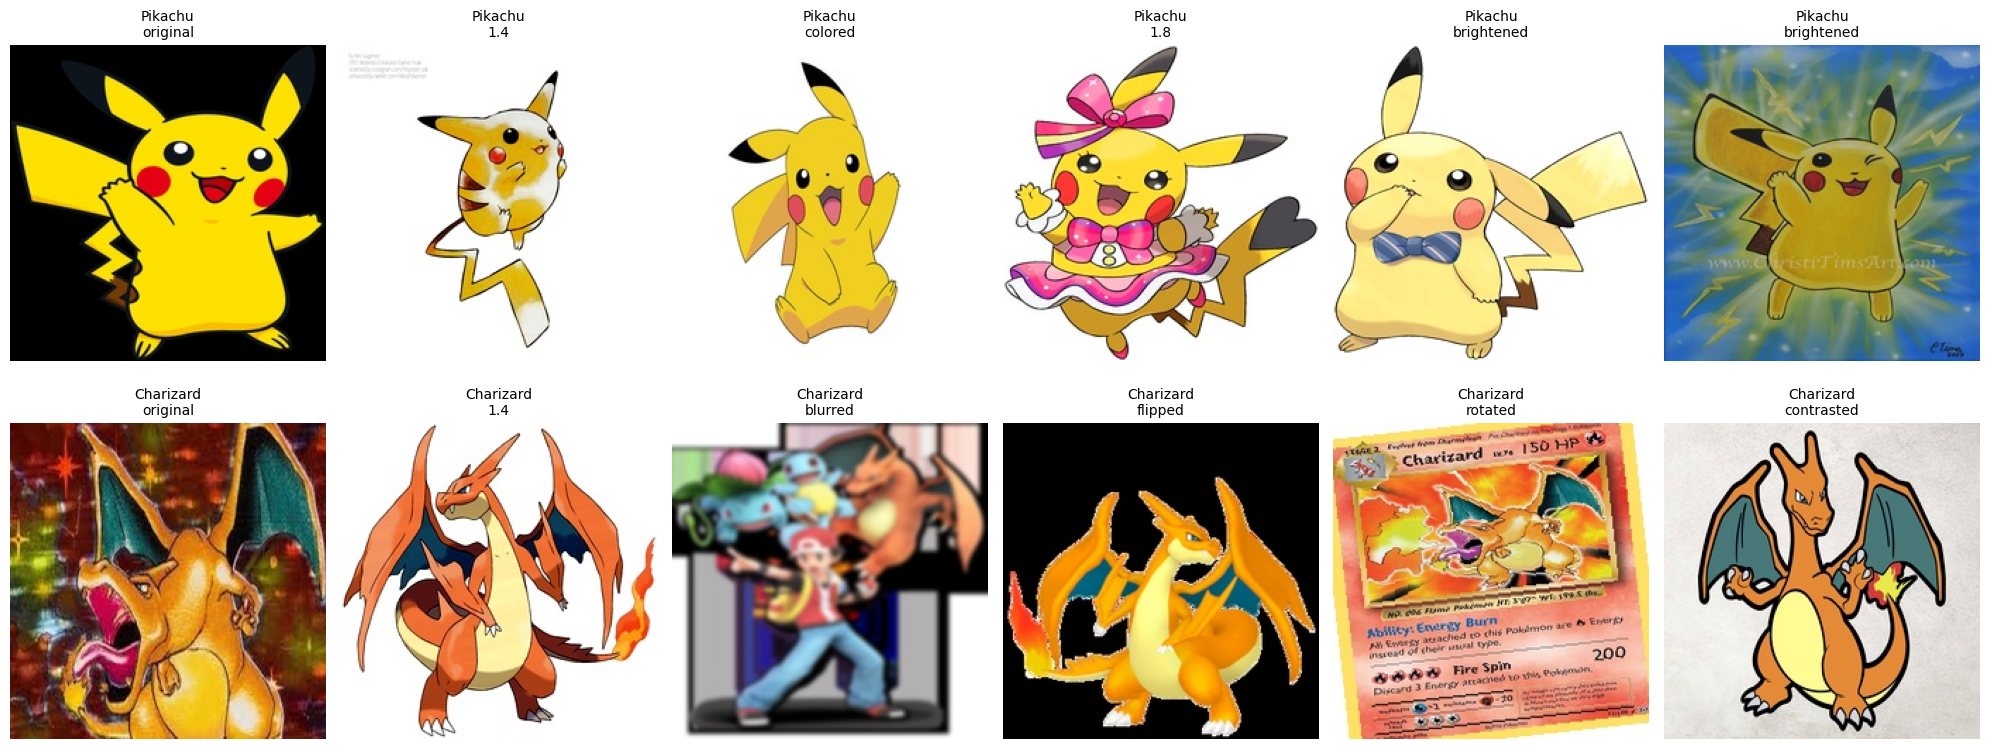


Complete! Your preprocessed Pokemon dataset is ready!
Preprocessed images: /content/drive/MyDrive/preprocessed_pokemon
Split dataset: /content/drive/MyDrive/pokemon_final_dataset


In [ ]:
# =============================================================================
# Data Preprocessing
# =============================================================================

import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import cv2
from pathlib import Path
from tqdm import tqdm  # For progress bar

def mount_google_drive():
    """Mount Google Drive in Colab environment"""
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted successfully!")
        return True
    except ImportError:
        print("Not running in Google Colab. Please provide local paths.")
        return False

def apply_augmentations(img, base_name):
    """
    Apply various augmentations to create distinct variations of the image

    Args:
        img: PIL Image object
        base_name: Base filename for saving

    Returns:
        Dictionary of augmented images
    """
    augmented_images = {}

    # 1. Rotation with more noticeable angles
    angles = [-30, -20, -10, 10, 20, 30]
    angle = random.choice(angles)
    rotated = img.rotate(angle, expand=False, fillcolor=(255, 255, 255))
    augmented_images[f'{base_name}_rotated_{abs(angle)}deg'] = rotated

    # 2. Horizontal flip (always apply, not random)
    flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
    augmented_images[f'{base_name}_flipped'] = flipped

    # 3. Brightness adjustment with more noticeable range
    brightness_factors = [0.5, 0.7, 1.3, 1.5]  # More dramatic changes
    bright_factor = random.choice(brightness_factors)
    enhancer = ImageEnhance.Brightness(img)
    brightened = enhancer.enhance(bright_factor)
    augmented_images[f'{base_name}_bright_{bright_factor}'] = brightened

    # 4. Contrast adjustment with more dramatic range
    contrast_factors = [0.5, 0.7, 1.4, 1.7]
    contrast_factor = random.choice(contrast_factors)
    enhancer = ImageEnhance.Contrast(img)
    contrasted = enhancer.enhance(contrast_factor)
    augmented_images[f'{base_name}_contrast_{contrast_factor}'] = contrasted

    # 5. Color saturation with wider range
    color_factors = [0.3, 0.6, 1.4, 1.8]
    color_factor = random.choice(color_factors)
    enhancer = ImageEnhance.Color(img)
    colored = enhancer.enhance(color_factor)
    augmented_images[f'{base_name}_color_{color_factor}'] = colored

    # 6. Gaussian blur
    blurred = img.filter(ImageFilter.GaussianBlur(radius=1.5))
    augmented_images[f'{base_name}_blurred'] = blurred

    # 7. Sharpness adjustment
    sharpness_factors = [0.5, 2.0]
    sharp_factor = random.choice(sharpness_factors)
    enhancer = ImageEnhance.Sharpness(img)
    sharpened = enhancer.enhance(sharp_factor)
    augmented_images[f'{base_name}_sharp_{sharp_factor}'] = sharpened

    # 8. Crop and resize (zoom effect)
    width, height = img.size
    crop_factor = random.uniform(0.8, 0.95)  # Crop 5-20% from edges
    crop_width = int(width * crop_factor)
    crop_height = int(height * crop_factor)

    left = (width - crop_width) // 2
    top = (height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height

    cropped = img.crop((left, top, right, bottom))
    zoomed = cropped.resize((width, height), Image.Resampling.LANCZOS)
    augmented_images[f'{base_name}_zoomed'] = zoomed

    # 9. Add slight noise (using PIL operations)
    # Convert to numpy for noise
    img_array = np.array(img)
    noise = np.random.normal(0, 15, img_array.shape).astype(np.int16)
    noisy_array = np.clip(img_array.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    noisy = Image.fromarray(noisy_array)
    augmented_images[f'{base_name}_noisy'] = noisy

    # 10. Perspective transformation (simple skew)
    # This is a basic implementation
    width, height = img.size
    skew_factor = random.uniform(-0.1, 0.1)

    # Simple shear transformation using transform method
    sheared = img.transform(
        (width, height),
        Image.AFFINE,
        (1, skew_factor, 0, 0, 1, 0),
        fillcolor=(255, 255, 255)
    )
    augmented_images[f'{base_name}_sheared'] = sheared

    return augmented_images

def preprocess_pokemon_dataset(
    input_drive_path,
    output_local_path,
    apply_augmentation=True,
    resize_to=(224, 224),
    quality=95,
    max_images_per_class=None,
    num_augmentations_per_image=5  # How many augmentations to apply per original image
):
    """
    Comprehensive Pokemon dataset preprocessing with improved augmentation

    Args:
        input_drive_path: Path to Pokemon dataset in Google Drive
        output_local_path: Local path to save preprocessed images
        apply_augmentation: Whether to apply data augmentation
        resize_to: Target size for images (width, height)
        quality: JPEG quality for saved images
        max_images_per_class: Maximum images to process per Pokemon class
        num_augmentations_per_image: Number of augmented versions per original image
    """

    print("="*60)
    print("POKEMON DATASET PREPROCESSING PIPELINE (IMPROVED)")
    print("="*60)

    # Check if input directory exists
    if not os.path.exists(input_drive_path):
        print(f"Input directory not found: {input_drive_path}")
        return False

    # Create output directory
    os.makedirs(output_local_path, exist_ok=True)
    print(f"Output directory created: {output_local_path}")

    # Get all Pokemon class directories
    pokemon_classes = [d for d in os.listdir(input_drive_path)
                      if os.path.isdir(os.path.join(input_drive_path, d))]

    if not pokemon_classes:
        print("No Pokemon class directories found!")
        return False

    print(f"Found {len(pokemon_classes)} Pokemon classes: {pokemon_classes[:5]}...")

    total_processed = 0
    processing_stats = {}

    # Process each Pokemon class
    for pokemon_idx, pokemon_name in enumerate(pokemon_classes):
        print(f"\nProcessing {pokemon_idx+1}/{len(pokemon_classes)}: {pokemon_name}")

        src_dir = os.path.join(input_drive_path, pokemon_name)
        dst_dir = os.path.join(output_local_path, pokemon_name)
        os.makedirs(dst_dir, exist_ok=True)

        # Get all image files
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')
        image_files = [f for f in os.listdir(src_dir)
                      if f.lower().endswith(image_extensions)]

        if max_images_per_class:
            image_files = image_files[:max_images_per_class]

        print(f"   Found {len(image_files)} images")

        # Skip if no images found
        if len(image_files) == 0:
            print(f"   Warning: No images found in {pokemon_name} directory")
            processing_stats[pokemon_name] = {
                'valid': 0,
                'corrupted': 0,
                'total': 0,
                'augmented_total': 0
            }
            continue

        valid_count = 0
        corrupted_count = 0
        total_images_created = 0

        # Process each image with progress bar
        for img_idx, img_file in enumerate(tqdm(image_files, desc=f"Processing {pokemon_name}")):
            src_path = os.path.join(src_dir, img_file)

            try:
                # Load and verify image
                with Image.open(src_path) as img:
                    # Convert to RGB (handles RGBA, grayscale, etc.)
                    img = img.convert('RGB')

                    # Basic preprocessing
                    img_resized = img.resize(resize_to, Image.Resampling.LANCZOS)

                    # Save original processed image
                    base_name = f"{pokemon_name}_{valid_count+1:04d}"
                    original_path = os.path.join(dst_dir, f"{base_name}_original.jpg")
                    img_resized.save(original_path, 'JPEG', quality=quality, optimize=True)
                    total_images_created += 1

                    # Apply augmentations if requested
                    if apply_augmentation:
                        # Get all possible augmentations
                        all_augmentations = apply_augmentations(img_resized, base_name)

                        # Randomly select specified number of augmentations
                        selected_augmentations = dict(random.sample(
                            list(all_augmentations.items()),
                            min(num_augmentations_per_image, len(all_augmentations))
                        ))

                        # Save selected augmentations
                        for aug_name, aug_img in selected_augmentations.items():
                            aug_path = os.path.join(dst_dir, f"{aug_name}.jpg")
                            aug_img.save(aug_path, 'JPEG', quality=quality, optimize=True)
                            total_images_created += 1

                    valid_count += 1

            except Exception as e:
                corrupted_count += 1
                print(f"   Warning: Corrupted image: {img_file} - {str(e)}")

        # Store processing statistics
        processing_stats[pokemon_name] = {
            'valid': valid_count,
            'corrupted': corrupted_count,
            'total': len(image_files),
            'augmented_total': total_images_created
        }

        total_processed += total_images_created
        print(f"   Processed: {valid_count} valid images -> {total_images_created} total images")

    # Print final statistics
    print("\n" + "="*60)
    print("PREPROCESSING COMPLETE!")
    print("="*60)
    print(f"Total images created: {total_processed}")
    print(f"Output saved to: {output_local_path}")

    # Detailed statistics
    print(f"\nClass-wise Statistics:")
    for pokemon, stats in processing_stats.items():
        print(f"   {pokemon}: {stats['valid']} original -> {stats['augmented_total']} total")

    return True, processing_stats

def create_dataset_splits(processed_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split the preprocessed dataset into train/val/test sets"""
    print(f"\nCreating dataset splits...")

    # Create directories
    splits = ['train', 'val', 'test']
    ratios = [train_ratio, val_ratio, test_ratio]

    for split in splits:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    pokemon_classes = [d for d in os.listdir(processed_dir)
                      if os.path.isdir(os.path.join(processed_dir, d))]

    split_stats = {split: {} for split in splits}

    for pokemon in pokemon_classes:
        src_dir = os.path.join(processed_dir, pokemon)
        images = [f for f in os.listdir(src_dir) if f.lower().endswith('.jpg')]

        # Skip if no images
        if len(images) == 0:
            print(f"   Warning: No images found for {pokemon}")
            for split in splits:
                split_stats[split][pokemon] = 0
            continue

        # Shuffle images
        random.shuffle(images)
        n_images = len(images)

        # Calculate split indices
        train_end = int(n_images * train_ratio)
        val_end = train_end + int(n_images * val_ratio)

        image_splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        # Copy images to respective directories
        for split, split_images in image_splits.items():
            split_dir = os.path.join(output_dir, split, pokemon)
            os.makedirs(split_dir, exist_ok=True)

            for img in split_images:
                src_path = os.path.join(src_dir, img)
                dst_path = os.path.join(split_dir, img)
                shutil.copy2(src_path, dst_path)

            split_stats[split][pokemon] = len(split_images)

    # Print split statistics
    print(f"Dataset Split Summary:")
    for split in splits:
        total_images = sum(split_stats[split].values())
        print(f"   {split.upper()}: {total_images} images across {len(split_stats[split])} classes")

    return split_stats

def visualize_preprocessing_results(processed_dir, num_classes=3, images_per_class=6):
    """Visualize some preprocessing results to show augmentation differences"""
    pokemon_classes = [d for d in os.listdir(processed_dir)
                      if os.path.isdir(os.path.join(processed_dir, d))][:num_classes]

    # Filter out classes with no images
    pokemon_classes = [pokemon for pokemon in pokemon_classes
                      if len([f for f in os.listdir(os.path.join(processed_dir, pokemon))
                             if f.lower().endswith('.jpg')]) > 0]

    if len(pokemon_classes) == 0:
        print("No classes with images found for visualization")
        return

    fig, axes = plt.subplots(len(pokemon_classes), images_per_class,
                            figsize=(20, 4*len(pokemon_classes)))

    if len(pokemon_classes) == 1:
        axes = axes.reshape(1, -1)

    for class_idx, pokemon in enumerate(pokemon_classes):
        class_dir = os.path.join(processed_dir, pokemon)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]

        if len(images) == 0:
            continue

        # Try to get one original and several augmented versions
        original_images = [img for img in images if 'original' in img]
        augmented_images = [img for img in images if 'original' not in img]

        selected_images = []
        if original_images:
            selected_images.append(original_images[0])

        if augmented_images:
            # Add some augmented versions
            selected_images.extend(random.sample(
                augmented_images,
                min(images_per_class - len(selected_images), len(augmented_images))
            ))

        # Fill remaining slots if needed
        while len(selected_images) < images_per_class and len(selected_images) < len(images):
            remaining_images = [img for img in images if img not in selected_images]
            if remaining_images:
                selected_images.append(random.choice(remaining_images))
            else:
                break

        for img_idx, img_file in enumerate(selected_images):
            if img_idx >= images_per_class:
                break

            img_path = os.path.join(class_dir, img_file)
            img = Image.open(img_path)

            axes[class_idx, img_idx].imshow(img)
            # Show the augmentation type in title
            aug_type = img_file.split('_')[-1].replace('.jpg', '') if '_' in img_file else 'original'
            axes[class_idx, img_idx].set_title(f"{pokemon}\n{aug_type}", fontsize=10)
            axes[class_idx, img_idx].axis('off')

        # Hide unused subplots
        for img_idx in range(len(selected_images), images_per_class):
            axes[class_idx, img_idx].axis('off')

    plt.tight_layout()
    plt.show()

# MAIN EXECUTION SCRIPT
def run_complete_preprocessing():
    """Complete preprocessing pipeline with improved augmentation"""

    # Step 1: Mount Google Drive (if in Colab)
    print("Mounting Google Drive...")
    drive_mounted = mount_google_drive()

    # Step 2: Set paths
    if drive_mounted:
        # Google Colab paths
        input_path = "/content/drive/MyDrive/pokemon_dataset/raw"
        output_path = "/content/drive/MyDrive/preprocessed_pokemon"
        final_output_path = "/content/drive/MyDrive/pokemon_final_dataset"
    else:
        # Local paths
        input_path = "path/to/your/pokemon/dataset"
        output_path = "./preprocessed_pokemon"
        final_output_path = "./pokemon_final_dataset"

    print(f"Input path: {input_path}")
    print(f"Output path: {output_path}")

    # Step 3: Preprocess dataset with improved augmentation
    success, stats = preprocess_pokemon_dataset(
        input_drive_path=input_path,
        output_local_path=output_path,
        apply_augmentation=True,
        resize_to=(224, 224),
        quality=95,
        max_images_per_class=100,  # Limit for demo, set to None for all images
        num_augmentations_per_image=5  # Create 5 augmented versions per original
    )

    if not success:
        print("Preprocessing failed!")
        return

    # Step 4: Create train/val/test splits
    split_stats = create_dataset_splits(
        processed_dir=output_path,
        output_dir=final_output_path,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15
    )

    # Step 5: Visualize results
    print(f"\nVisualizing preprocessing results...")
    visualize_preprocessing_results(output_path, num_classes=3, images_per_class=6)

    print(f"\nComplete! Your preprocessed Pokemon dataset is ready!")
    print(f"Preprocessed images: {output_path}")
    print(f"Split dataset: {final_output_path}")

    return output_path, final_output_path

if __name__ == "__main__":
    # Run the complete preprocessing pipeline
    run_complete_preprocessing()

In [ ]:
# =============================================================================
# MODEL BUILDING AND UTILITIES
# =============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import copy

# =============================================================================
# MODEL DEFINITIONS
# =============================================================================

def create_mobilenetv2_model(num_classes, pretrained=True):
    """Create a MobileNetV2 model with transfer learning"""
    model = models.mobilenet_v2(pretrained=pretrained)

    if pretrained:
        # Freeze feature extraction layers
        for param in model.features.parameters():
            param.requires_grad = False

    # Replace classifier
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.last_channel, num_classes)
    )

    return model

def create_resnet18_model(num_classes, pretrained=True):
    """Create a ResNet18 model with transfer learning"""
    model = models.resnet18(pretrained=pretrained)

    if pretrained:
        # Freeze early layers, allow fine-tuning of later layers
        for name, param in model.named_parameters():
            if "layer4" not in name and "fc" not in name:
                param.requires_grad = False

    # Replace final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, num_classes)
    )

    return model

class CustomCNN(nn.Module):
    """Custom CNN model built from scratch for Pokemon classification"""
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Forward pass through convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)

        # Global average pooling and flatten
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def create_model(model_name, num_classes, pretrained=True):
    """Factory function to create a model based on the specified name"""
    if model_name == 'mobilenetv2':
        return create_mobilenetv2_model(num_classes, pretrained)
    elif model_name == 'resnet18':
        return create_resnet18_model(num_classes, pretrained)
    elif model_name == 'custom':
        return CustomCNN(num_classes)
    else:
        raise ValueError(f"Unknown model name: {model_name}. Choose from: 'mobilenetv2', 'resnet18', 'custom'")

# =============================================================================
# DATA LOADING FUNCTIONS
# =============================================================================

def create_data_transforms():
    """Create data transformations for training and validation"""
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    return data_transforms

def create_dataloaders(data_dir, batch_size=32, num_workers=2):
    """Create data loaders for train, validation, and test sets"""
    data_transforms = create_data_transforms()

    # Check if data directory exists
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Data directory not found: {data_dir}")

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    # Create datasets and dataloaders for each split
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(data_dir, split)
        if os.path.exists(split_dir):
            image_datasets[split] = datasets.ImageFolder(
                split_dir,
                transform=data_transforms[split]
            )
            dataloaders[split] = DataLoader(
                image_datasets[split],
                batch_size=batch_size,
                shuffle=(split == 'train'),  # Only shuffle training data
                num_workers=num_workers,
                pin_memory=True
            )
            dataset_sizes[split] = len(image_datasets[split])
        else:
            print(f"Warning: {split} directory not found at {split_dir}")

    # Get class names from training dataset
    if 'train' in image_datasets:
        class_names = image_datasets['train'].classes
        class_to_idx = image_datasets['train'].class_to_idx
    else:
        raise FileNotFoundError("Training data not found!")

    return {
        'dataloaders': dataloaders,
        'dataset_sizes': dataset_sizes,
        'class_names': class_names,
        'class_to_idx': class_to_idx
    }

# =============================================================================
# MODEL SAVING AND LOADING
# =============================================================================

def save_model(model, class_to_idx, model_path, additional_info=None):
    """Save the model checkpoint with all necessary information"""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'class_to_idx': class_to_idx,
        'num_classes': len(class_to_idx)
    }

    if additional_info:
        checkpoint.update(additional_info)

    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(model_path), exist_ok=True)

    torch.save(checkpoint, model_path)
    print(f"Model saved to {model_path}")

def load_model(model_name, model_path, device='cpu'):
    """Load a saved model checkpoint"""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    checkpoint = torch.load(model_path, map_location=device)

    class_to_idx = checkpoint['class_to_idx']
    num_classes = checkpoint.get('num_classes', len(class_to_idx))

    # Create model
    model = create_model(model_name, num_classes, pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    return model, class_to_idx

# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_confusion_matrix(cm, class_names, output_path=None, normalize=False):
    """Plot and save a confusion matrix"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
        fmt = '.2f'
    else:
        title = 'Confusion Matrix'
        fmt = 'd'

    plt.figure(figsize=(max(8, len(class_names) * 0.8), max(6, len(class_names) * 0.6)))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=8)

    plt.tight_layout()
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {output_path}")

    plt.show()

def visualize_predictions(model, dataloader, class_names, device, num_images=8):
    """Visualize model predictions on a batch of images"""
    model.eval()

    # Get a batch of data
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images = images.to(device)
    labels = labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)

    # Plot images with predictions
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(min(num_images, len(images))):
        # Denormalize image for display
        img = images[i].cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)

        axes[i].imshow(img)

        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        confidence = probs[i][preds[i]].item() * 100

        color = 'green' if preds[i] == labels[i] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Model building utilities loaded successfully!")
print("Available models: 'mobilenetv2', 'resnet18', 'custom'")
print("Ready for training setup...")

Model building utilities loaded successfully!
Available models: 'mobilenetv2', 'resnet18', 'custom'
Ready for training setup...


In [ ]:
# =============================================================================
# COMPLETE POKEMON CLASSIFIER TRAINING PIPELINE
# =============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import copy
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# COMPLETE TRAINING FUNCTIONS (Fixed and Enhanced)
# =============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device, epoch_num):
    """Train the model for one epoch"""
    model.train()

    running_loss = 0.0
    running_corrects = 0

    # Progress bar for training
    pbar = tqdm(dataloader, desc=f"Epoch {epoch_num} - Training")

    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Update progress bar
        current_loss = running_loss / ((batch_idx + 1) * inputs.size(0))
        current_acc = running_corrects.double() / ((batch_idx + 1) * inputs.size(0))
        pbar.set_postfix({'Loss': f'{current_loss:.4f}', 'Acc': f'{current_acc:.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc.item()

def validate_epoch(model, dataloader, criterion, device, phase="Validation"):
    """Validate the model"""
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    # Progress bar for validation
    pbar = tqdm(dataloader, desc=f"{phase}")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Update progress bar
            current_loss = running_loss / ((batch_idx + 1) * inputs.size(0))
            current_acc = running_corrects.double() / ((batch_idx + 1) * inputs.size(0))
            pbar.set_postfix({'Loss': f'{current_loss:.4f}', 'Acc': f'{current_acc:.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc.item()

def evaluate_model(model, dataloader, device, class_names):
    """Evaluate the model and generate detailed metrics"""
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Calculate per-class accuracy
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    return {
        'confusion_matrix': cm,
        'confusion_matrix_percent': cm_percent,
        'classification_report': report,
        'accuracy': report['accuracy'],
        'all_preds': all_preds,
        'all_labels': all_labels,
        'all_probs': all_probs
    }

def train_pokemon_model(model, dataloaders, criterion, optimizer, scheduler, device,
                       num_epochs, model_dir, class_names, class_to_idx):
    """Complete training pipeline"""

    # Create model directory
    os.makedirs(model_dir, exist_ok=True)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    best_epoch = 0

    print("="*60)
    print("STARTING POKEMON CLASSIFIER TRAINING")
    print("="*60)
    print(f"Device: {device}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Training samples: {len(dataloaders['train'].dataset)}")
    print(f"Validation samples: {len(dataloaders['val'].dataset)}")
    if 'test' in dataloaders:
        print(f"Test samples: {len(dataloaders['test'].dataset)}")
    print("="*60)

    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training phase
        train_loss, train_acc = train_epoch(model, dataloaders['train'], criterion, optimizer, device, epoch+1)
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

        # Validation phase
        val_loss, val_acc = validate_epoch(model, dataloaders['val'], criterion, device)
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Learning rate scheduling
        if scheduler is not None:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

            current_lr = optimizer.param_groups[0]['lr']
            print(f"Learning Rate: {current_lr:.2e}")

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_loss = val_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())

            # Save checkpoint
            checkpoint_path = os.path.join(model_dir, f"pokemon_model_epoch_{epoch+1}.pt")
            save_model(model, class_to_idx, checkpoint_path, {
                'epoch': epoch+1,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            })

            print(f"★ New best model saved! Val Acc: {best_acc:.4f}")

        print("-" * 30)

    # Training complete
    time_elapsed = time.time() - since
    print(f"\n{'='*60}")
    print("TRAINING COMPLETE!")
    print(f"{'='*60}")
    print(f"Training time: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f} at epoch {best_epoch+1}")
    print(f"Best Val Loss: {best_loss:.4f}")

    # Load best model
    model.load_state_dict(best_model_wts)

    # Save final best model
    best_model_path = os.path.join(model_dir, "best_pokemon_model.pt")
    save_model(model, class_to_idx, best_model_path, {
        'best_epoch': best_epoch+1,
        'best_val_acc': best_acc,
        'best_val_loss': best_loss,
        'history': history,
        'training_time': time_elapsed
    })

    return model, history

def plot_training_history(history, output_path=None):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss plot
    axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', color='red')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy plot
    axes[0, 1].plot(history['train_acc'], label='Train Acc', color='blue')
    axes[0, 1].plot(history['val_acc'], label='Val Acc', color='red')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Learning rate plot
    axes[1, 0].plot(history['lr'], color='green')
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True)

    # Combined loss and accuracy
    ax1 = axes[1, 1]
    ax2 = ax1.twinx()

    line1 = ax1.plot(history['train_loss'], label='Train Loss', color='blue', linestyle='--')
    line2 = ax1.plot(history['val_loss'], label='Val Loss', color='red', linestyle='--')
    line3 = ax2.plot(history['train_acc'], label='Train Acc', color='blue')
    line4 = ax2.plot(history['val_acc'], label='Val Acc', color='red')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='black')
    ax2.set_ylabel('Accuracy', color='black')
    ax1.set_title('Loss and Accuracy Combined')

    # Combine legends
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')

    ax1.grid(True)

    plt.tight_layout()

    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Training history plot saved to {output_path}")

    plt.show()

def plot_confusion_matrix(cm, class_names, output_path=None, normalize=False):
    """Plot and save a confusion matrix"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
        fmt = '.2f'
    else:
        title = 'Confusion Matrix'
        fmt = 'd'

    plt.figure(figsize=(max(8, len(class_names) * 0.8), max(6, len(class_names) * 0.6)))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=8)

    plt.tight_layout()
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {output_path}")

    plt.show()

def visualize_predictions(model, dataloader, class_names, device, num_images=8):
    """Visualize model predictions on a batch of images"""
    model.eval()

    # Get a batch of data
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images = images.to(device)
    labels = labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)

    # Plot images with predictions
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(min(num_images, len(images))):
        # Denormalize image for display
        img = images[i].cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)

        axes[i].imshow(img)

        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        confidence = probs[i][preds[i]].item() * 100

        color = 'green' if preds[i] == labels[i] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# =============================================================================
# COMPLETE MAIN TRAINING PIPELINE (FIXED AND ENHANCED)
# =============================================================================

def run_pokemon_training(
    data_dir="/content/drive/MyDrive/pokemon_final_dataset",
    model_dir="/content/drive/MyDrive/pokemon_models",
    model_name="mobilenetv2",  # Options: 'mobilenetv2', 'resnet18', 'custom'
    num_epochs=25,
    batch_size=32,
    learning_rate=0.001,
    num_workers=2,
    pretrained=True
):
    """Complete Pokemon training pipeline"""

    print("="*60)
    print("POKEMON CLASSIFIER TRAINING PIPELINE")
    print("="*60)

    # Check if data directory exists
    if not os.path.exists(data_dir):
        print(f"❌ Data directory not found: {data_dir}")
        print("Please update the data_dir path to your preprocessed Pokemon dataset")
        return None

    try:
        # Create dataloaders
        print("📊 Loading dataset...")
        data = create_dataloaders(data_dir, batch_size, num_workers)
        dataloaders = data['dataloaders']
        dataset_sizes = data['dataset_sizes']
        class_names = data['class_names']
        class_to_idx = data['class_to_idx']

        print(f"✅ Dataset loaded successfully!")
        print(f"   - Classes: {len(class_names)}")
        print(f"   - Training samples: {dataset_sizes.get('train', 0)}")
        print(f"   - Validation samples: {dataset_sizes.get('val', 0)}")
        print(f"   - Test samples: {dataset_sizes.get('test', 0)}")
        print(f"   - Pokemon classes: {class_names[:5]}..." if len(class_names) > 5 else f"   - Pokemon classes: {class_names}")

        # Set device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"🖥️  Using device: {device}")

        # Create model
        print(f"🧠 Creating {model_name} model...")
        model = create_model(model_name, len(class_names), pretrained)
        model = model.to(device)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"   - Total parameters: {total_params:,}")
        print(f"   - Trainable parameters: {trainable_params:,}")

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Learning rate scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5,
            verbose=True, min_lr=1e-7
        )

        print(f"🏋️  Training configuration:")
        print(f"   - Model: {model_name}")
        print(f"   - Epochs: {num_epochs}")
        print(f"   - Batch size: {batch_size}")
        print(f"   - Learning rate: {learning_rate}")
        print(f"   - Optimizer: Adam")
        print(f"   - Scheduler: ReduceLROnPlateau")

        # Train model
        trained_model, history = train_pokemon_model(
            model, dataloaders, criterion, optimizer, scheduler,
            device, num_epochs, model_dir, class_names, class_to_idx
        )

        # Plot training history
        print("\n📈 Generating training plots...")
        history_plot_path = os.path.join(model_dir, "training_history.png")
        plot_training_history(history, history_plot_path)

        # Evaluate on test set
        if 'test' in dataloaders:
            print("\n🧪 Evaluating on test set...")
            test_metrics = evaluate_model(trained_model, dataloaders['test'], device, class_names)

            print(f"✅ Test Results:")
            print(f"   - Test Accuracy: {test_metrics['accuracy']:.4f}")

            # Plot confusion matrix
            cm_path = os.path.join(model_dir, "confusion_matrix.png")
            plot_confusion_matrix(test_metrics['confusion_matrix'], class_names, cm_path)

            # Plot normalized confusion matrix
            cm_norm_path = os.path.join(model_dir, "confusion_matrix_normalized.png")
            plot_confusion_matrix(test_metrics['confusion_matrix'], class_names, cm_norm_path, normalize=True)

            # Visualize predictions
            print("\n🔍 Visualizing model predictions...")
            visualize_predictions(trained_model, dataloaders['test'], class_names, device)

            # Print detailed classification report
            print("\n📊 Detailed Classification Report:")
            report = test_metrics['classification_report']
            for pokemon in class_names:
                if pokemon in report:
                    metrics = report[pokemon]
                    print(f"{pokemon:15} - Precision: {metrics['precision']:.3f}, "
                          f"Recall: {metrics['recall']:.3f}, F1: {metrics['f1-score']:.3f}")

        print(f"\n🎉 Training completed successfully!")
        print(f"   - Best model saved to: {os.path.join(model_dir, 'best_pokemon_model.pt')}")
        print(f"   - Training plots saved to: {model_dir}")

        return {
            'model': trained_model,
            'history': history,
            'class_names': class_names,
            'class_to_idx': class_to_idx,
            'test_metrics': test_metrics if 'test' in dataloaders else None
        }

    except Exception as e:
        print(f"❌ Error during training: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# =============================================================================
# EXAMPLE USAGE AND MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Example 1: Train MobileNetV2 (Recommended for quick training)
    #print("Starting MobileNetV2 training...")
    #results_mobilenet = run_pokemon_training(
        #data_dir="/content/drive/MyDrive/pokemon_final_dataset",  # Update this path!
        #model_dir="/content/drive/MyDrive/pokemon_models/mobilenetv2",
        #model_name="mobilenetv2",
        #num_epochs=15,
        #batch_size=32,
        #learning_rate=0.001,
        #num_workers=2,
        #pretrained=True
    #)

    # Example 2: Train ResNet18 (Uncomment to run)
    print("\nStarting ResNet18 training...")
    results_resnet = run_pokemon_training(
        data_dir="/content/drive/MyDrive/pokemon_final_dataset",
        model_dir="/content/drive/MyDrive/pokemon_models/resnet18",
        model_name="resnet18",
        num_epochs=20,
        batch_size=32,
        learning_rate=0.001,
        num_workers=2,
        pretrained=True
    )

    # Example 3: Train Custom CNN (Uncomment to run)
    # print("\nStarting Custom CNN training...")
    # results_custom = run_pokemon_training(
    #     data_dir="/content/drive/MyDrive/pokemon_final_dataset",
    #     model_dir="/content/drive/MyDrive/pokemon_models/custom",
    #     model_name="custom",
    #     num_epochs=30,
    #     batch_size=16,  # Smaller batch size for custom model
    #     learning_rate=0.0005,
    #     num_workers=2,
    #     pretrained=False  # No pretrained weights for custom model
    # )

    print("\n" + "="*60)
    print("ALL TRAINING COMPLETED!")
    print("="*60)


Starting Custom CNN training...
POKEMON CLASSIFIER TRAINING PIPELINE
📊 Loading dataset...
✅ Dataset loaded successfully!
   - Classes: 20
   - Training samples: 6438
   - Validation samples: 1689
   - Test samples: 1757
   - Pokemon classes: ['Articuno', 'Bulbasaur', 'Charizard', 'Dragonite', 'Eevee']...
🖥️  Using device: cpu
🧠 Creating custom model...
   - Total parameters: 1,707,028
   - Trainable parameters: 1,707,028
🏋️  Training configuration:
   - Model: custom
   - Epochs: 30
   - Batch size: 16
   - Learning rate: 0.0005
   - Optimizer: Adam
   - Scheduler: ReduceLROnPlateau
STARTING POKEMON CLASSIFIER TRAINING
Device: cpu
Number of classes: 20
Training samples: 6438
Validation samples: 1689
Test samples: 1757

Epoch 1/30
------------------------------


Epoch 1 - Training: 100%|██████████| 403/403 [27:46<00:00,  4.14s/it, Loss=7.0194, Acc=0.4053]


Train Loss: 2.6364 | Train Acc: 0.1522


Validation: 100%|██████████| 106/106 [04:03<00:00,  2.30s/it, Loss=4.0830, Acc=0.4119]


Val Loss: 2.3062 | Val Acc: 0.2327
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_1.pt
★ New best model saved! Val Acc: 0.2327
------------------------------

Epoch 2/30
------------------------------


Epoch 2 - Training: 100%|██████████| 403/403 [26:15<00:00,  3.91s/it, Loss=6.3929, Acc=0.5897]


Train Loss: 2.4011 | Train Acc: 0.2215


Validation: 100%|██████████| 106/106 [02:45<00:00,  1.56s/it, Loss=3.6691, Acc=0.5618]


Val Loss: 2.0724 | Val Acc: 0.3173
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_2.pt
★ New best model saved! Val Acc: 0.3173
------------------------------

Epoch 3/30
------------------------------


Epoch 3 - Training: 100%|██████████| 403/403 [26:01<00:00,  3.88s/it, Loss=5.9801, Acc=0.7295]


Train Loss: 2.2460 | Train Acc: 0.2740


Validation: 100%|██████████| 106/106 [02:52<00:00,  1.63s/it, Loss=3.3274, Acc=0.6771]


Val Loss: 1.8794 | Val Acc: 0.3825
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_3.pt
★ New best model saved! Val Acc: 0.3825
------------------------------

Epoch 4/30
------------------------------


Epoch 4 - Training: 100%|██████████| 403/403 [25:53<00:00,  3.86s/it, Loss=5.6684, Acc=0.8238]


Train Loss: 2.1289 | Train Acc: 0.3094


Validation: 100%|██████████| 106/106 [02:50<00:00,  1.61s/it, Loss=3.0518, Acc=0.7799]


Val Loss: 1.7237 | Val Acc: 0.4405
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_4.pt
★ New best model saved! Val Acc: 0.4405
------------------------------

Epoch 5/30
------------------------------


Epoch 5 - Training: 100%|██████████| 403/403 [25:58<00:00,  3.87s/it, Loss=5.3885, Acc=0.9268]


Train Loss: 2.0238 | Train Acc: 0.3481


Validation: 100%|██████████| 106/106 [02:52<00:00,  1.63s/it, Loss=3.0290, Acc=0.7904]


Val Loss: 1.7109 | Val Acc: 0.4464
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_5.pt
★ New best model saved! Val Acc: 0.4464
------------------------------

Epoch 6/30
------------------------------


Epoch 6 - Training: 100%|██████████| 403/403 [25:32<00:00,  3.80s/it, Loss=5.1516, Acc=1.0070]


Train Loss: 1.9348 | Train Acc: 0.3782


Validation: 100%|██████████| 106/106 [02:40<00:00,  1.51s/it, Loss=2.8734, Acc=0.7987]


Val Loss: 1.6230 | Val Acc: 0.4512
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_6.pt
★ New best model saved! Val Acc: 0.4512
------------------------------

Epoch 7/30
------------------------------


Epoch 7 - Training: 100%|██████████| 403/403 [25:13<00:00,  3.76s/it, Loss=4.9210, Acc=1.0881]


Train Loss: 1.8482 | Train Acc: 0.4087


Validation: 100%|██████████| 106/106 [02:42<00:00,  1.53s/it, Loss=2.5523, Acc=0.9581]


Val Loss: 1.4416 | Val Acc: 0.5411
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_7.pt
★ New best model saved! Val Acc: 0.5411
------------------------------

Epoch 8/30
------------------------------


Epoch 8 - Training: 100%|██████████| 403/403 [25:24<00:00,  3.78s/it, Loss=4.6509, Acc=1.1679]


Train Loss: 1.7468 | Train Acc: 0.4386


Validation: 100%|██████████| 106/106 [02:51<00:00,  1.62s/it, Loss=2.6455, Acc=0.9161]


Val Loss: 1.4942 | Val Acc: 0.5175
Learning Rate: 5.00e-04
------------------------------

Epoch 9/30
------------------------------


Epoch 9 - Training: 100%|██████████| 403/403 [25:19<00:00,  3.77s/it, Loss=4.4558, Acc=1.2395]


Train Loss: 1.6735 | Train Acc: 0.4655


Validation: 100%|██████████| 106/106 [02:44<00:00,  1.56s/it, Loss=2.3898, Acc=1.0377]


Val Loss: 1.3499 | Val Acc: 0.5861
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_9.pt
★ New best model saved! Val Acc: 0.5861
------------------------------

Epoch 10/30
------------------------------


Epoch 10 - Training: 100%|██████████| 403/403 [25:40<00:00,  3.82s/it, Loss=4.2613, Acc=1.2692]


Train Loss: 1.6005 | Train Acc: 0.4767


Validation: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it, Loss=2.4127, Acc=0.9906]


Val Loss: 1.3628 | Val Acc: 0.5595
Learning Rate: 5.00e-04
------------------------------

Epoch 11/30
------------------------------


Epoch 11 - Training: 100%|██████████| 403/403 [25:44<00:00,  3.83s/it, Loss=4.0344, Acc=1.3594]


Train Loss: 1.5152 | Train Acc: 0.5106


Validation: 100%|██████████| 106/106 [02:19<00:00,  1.32s/it, Loss=1.9969, Acc=1.1698]


Val Loss: 1.1279 | Val Acc: 0.6607
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_11.pt
★ New best model saved! Val Acc: 0.6607
------------------------------

Epoch 12/30
------------------------------


Epoch 12 - Training: 100%|██████████| 403/403 [25:40<00:00,  3.82s/it, Loss=3.7280, Acc=1.4433]


Train Loss: 1.4002 | Train Acc: 0.5421


Validation: 100%|██████████| 106/106 [02:42<00:00,  1.54s/it, Loss=1.7921, Acc=1.1855]


Val Loss: 1.0122 | Val Acc: 0.6696
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_12.pt
★ New best model saved! Val Acc: 0.6696
------------------------------

Epoch 13/30
------------------------------


Epoch 13 - Training: 100%|██████████| 403/403 [25:08<00:00,  3.74s/it, Loss=3.5856, Acc=1.4934]


Train Loss: 1.3467 | Train Acc: 0.5609


Validation: 100%|██████████| 106/106 [02:47<00:00,  1.58s/it, Loss=1.8250, Acc=1.1981]


Val Loss: 1.0308 | Val Acc: 0.6767
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_13.pt
★ New best model saved! Val Acc: 0.6767
------------------------------

Epoch 14/30
------------------------------


Epoch 14 - Training: 100%|██████████| 403/403 [25:49<00:00,  3.85s/it, Loss=3.3926, Acc=1.5889]


Train Loss: 1.2742 | Train Acc: 0.5968


Validation: 100%|██████████| 106/106 [02:50<00:00,  1.60s/it, Loss=1.4339, Acc=1.3166]


Val Loss: 0.8099 | Val Acc: 0.7436
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_14.pt
★ New best model saved! Val Acc: 0.7436
------------------------------

Epoch 15/30
------------------------------


Epoch 15 - Training: 100%|██████████| 403/403 [25:55<00:00,  3.86s/it, Loss=3.1973, Acc=1.6261]


Train Loss: 1.2008 | Train Acc: 0.6107


Validation: 100%|██████████| 106/106 [02:44<00:00,  1.55s/it, Loss=1.4298, Acc=1.3302]


Val Loss: 0.8076 | Val Acc: 0.7513
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_15.pt
★ New best model saved! Val Acc: 0.7513
------------------------------

Epoch 16/30
------------------------------


Epoch 16 - Training: 100%|██████████| 403/403 [25:54<00:00,  3.86s/it, Loss=3.0512, Acc=1.6638]


Train Loss: 1.1460 | Train Acc: 0.6249


Validation: 100%|██████████| 106/106 [02:53<00:00,  1.64s/it, Loss=1.2033, Acc=1.3711]


Val Loss: 0.6797 | Val Acc: 0.7744
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_16.pt
★ New best model saved! Val Acc: 0.7744
------------------------------

Epoch 17/30
------------------------------


Epoch 17 - Training: 100%|██████████| 403/403 [25:53<00:00,  3.85s/it, Loss=2.8107, Acc=1.7411]


Train Loss: 1.0557 | Train Acc: 0.6539


Validation: 100%|██████████| 106/106 [02:52<00:00,  1.63s/it, Loss=1.5985, Acc=1.2642]


Val Loss: 0.9029 | Val Acc: 0.7140
Learning Rate: 5.00e-04
------------------------------

Epoch 18/30
------------------------------


Epoch 18 - Training: 100%|██████████| 403/403 [25:37<00:00,  3.81s/it, Loss=2.6595, Acc=1.7986]


Train Loss: 0.9988 | Train Acc: 0.6755


Validation: 100%|██████████| 106/106 [02:39<00:00,  1.50s/it, Loss=1.1442, Acc=1.4046]


Val Loss: 0.6463 | Val Acc: 0.7934
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_18.pt
★ New best model saved! Val Acc: 0.7934
------------------------------

Epoch 19/30
------------------------------


Epoch 19 - Training: 100%|██████████| 403/403 [25:06<00:00,  3.74s/it, Loss=2.5388, Acc=1.8205]


Train Loss: 0.9535 | Train Acc: 0.6838


Validation: 100%|██████████| 106/106 [02:24<00:00,  1.36s/it, Loss=1.0650, Acc=1.4214]


Val Loss: 0.6016 | Val Acc: 0.8028
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_19.pt
★ New best model saved! Val Acc: 0.8028
------------------------------

Epoch 20/30
------------------------------


Epoch 20 - Training: 100%|██████████| 403/403 [25:09<00:00,  3.75s/it, Loss=2.3031, Acc=1.9074]


Train Loss: 0.8650 | Train Acc: 0.7164


Validation: 100%|██████████| 106/106 [02:28<00:00,  1.40s/it, Loss=1.0781, Acc=1.4182]


Val Loss: 0.6089 | Val Acc: 0.8011
Learning Rate: 5.00e-04
------------------------------

Epoch 21/30
------------------------------


Epoch 21 - Training: 100%|██████████| 403/403 [25:43<00:00,  3.83s/it, Loss=2.1757, Acc=1.9603]


Train Loss: 0.8171 | Train Acc: 0.7363


Validation: 100%|██████████| 106/106 [02:56<00:00,  1.66s/it, Loss=1.1448, Acc=1.3721]


Val Loss: 0.6466 | Val Acc: 0.7750
Learning Rate: 5.00e-04
------------------------------

Epoch 22/30
------------------------------


Epoch 22 - Training: 100%|██████████| 403/403 [26:09<00:00,  3.90s/it, Loss=2.1917, Acc=1.9607]


Train Loss: 0.8232 | Train Acc: 0.7364


Validation: 100%|██████████| 106/106 [02:44<00:00,  1.55s/it, Loss=0.6830, Acc=1.5503]


Val Loss: 0.3858 | Val Acc: 0.8757
Learning Rate: 5.00e-04
Model saved to /content/drive/MyDrive/pokemon_models/custom/pokemon_model_epoch_22.pt
★ New best model saved! Val Acc: 0.8757
------------------------------

Epoch 23/30
------------------------------


Epoch 23 - Training: 100%|██████████| 403/403 [25:08<00:00,  3.74s/it, Loss=1.9579, Acc=2.0318]


Train Loss: 0.7354 | Train Acc: 0.7631


Validation: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it, Loss=0.9207, Acc=1.4633]


Val Loss: 0.5200 | Val Acc: 0.8265
Learning Rate: 5.00e-04
------------------------------

Epoch 24/30
------------------------------


Epoch 24 - Training: 100%|██████████| 403/403 [24:48<00:00,  3.69s/it, Loss=1.8163, Acc=2.0608]


Train Loss: 0.6822 | Train Acc: 0.7740


Validation:  31%|███       | 33/106 [00:50<01:40,  1.38s/it, Loss=0.4061, Acc=0.8883]

🚀 Pokemon Classifier Prediction Module
🖥️  Using device: cpu
🔄 Loading model from: /content/drive/MyDrive/pokemon_models/resnet18/best_pokemon_model.pt
✅ Model loaded successfully!
   - Model type: resnet18
   - Number of Pokemon classes: 20
   - Device: cpu
   - Best validation accuracy: 0.9923
   - Best epoch: 16
   - Pokemon classes (sample): ['Articuno', 'Bulbasaur', 'Charizard', 'Dragonite', 'Eevee', 'Flareon', 'Gengar', 'Gyarados', 'Jigglypuff', 'Jolteon']...

EXAMPLE 1: Local Image Prediction
🔍 Making prediction...

🎯 Prediction Results:
----------------------------------------
 1. Charizard       - 100.0%
----------------------------------------
🏆 Most likely Pokemon: Charizard (100.0%)

📊 Generating visualization...
💾 Visualization saved to: /content/drive/MyDrive/prediction_result.png


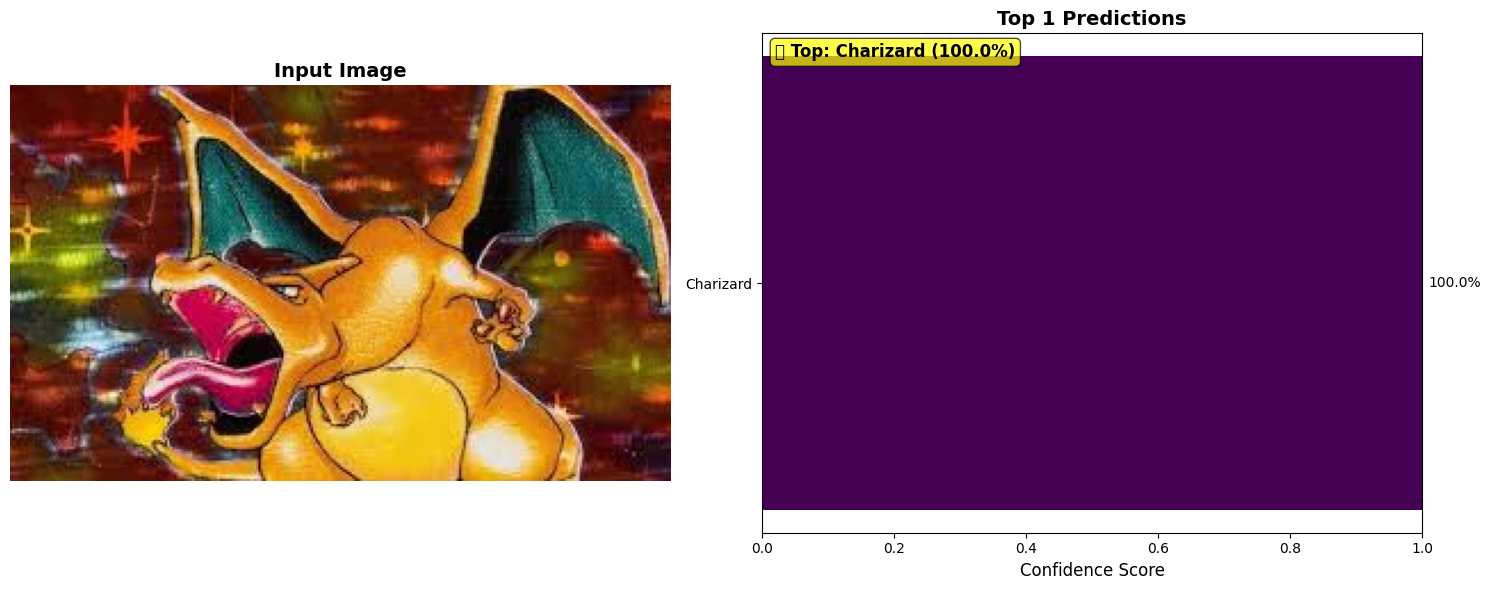


EXAMPLE 2: URL Image Prediction

🎉 Prediction complete!


'\nQUICK START GUIDE:\n\n1. Update Configuration:\n   - Set MODEL_PATH to your trained model file\n   - Set MODEL_NAME to match your training (\'mobilenetv2\', \'resnet18\', \'custom\')\n\n2. Basic Usage:\n   config = PokemonPredictorConfig()\n   config.MODEL_PATH = "path/to/your/model.pt"\n   config.MODEL_NAME = "mobilenetv2"\n\n   predictor = PokemonPredictor(config)\n   predictor.load_model()\n   result = predictor.predict_and_visualize("path/to/image.jpg")\n\n3. For Google Colab:\n   - Uncomment the drive.mount() line at the top\n   - Update all paths to use /content/drive/MyDrive/...\n\n4. Batch Processing:\n   results = batch_predict(predictor, list_of_image_paths, "output_directory")\n\n5. URL Images:\n   download_image_from_url(url, "temp.jpg")\n   result = predictor.predict("temp.jpg")\n'

In [ ]:
# =============================================================================
# POKEMON CLASSIFIER PREDICTION MODULE
# =============================================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# MODEL ARCHITECTURES
# =============================================================================

def create_mobilenetv2_model(num_classes, pretrained=True):
    """Create a MobileNetV2 model with transfer learning"""
    model = models.mobilenet_v2(pretrained=pretrained)

    if pretrained:
        # Freeze feature extraction layers
        for param in model.features.parameters():
            param.requires_grad = False

    # Replace classifier
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.last_channel, num_classes)
    )

    return model

def create_resnet18_model(num_classes, pretrained=True):
    """Create a ResNet18 model with transfer learning"""
    model = models.resnet18(pretrained=pretrained)

    if pretrained:
        # Freeze early layers, allow fine-tuning of later layers
        for name, param in model.named_parameters():
            if "layer4" not in name and "fc" not in name:
                param.requires_grad = False

    # Replace final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, num_classes)
    )

    return model

class CustomCNN(nn.Module):
    """Custom CNN model built from scratch for Pokemon classification"""
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Forward pass through convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)

        # Global average pooling and flatten
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def create_model(model_name, num_classes, pretrained=True):
    """Factory function to create a model based on the specified name"""
    if model_name == 'mobilenetv2':
        return create_mobilenetv2_model(num_classes, pretrained)
    elif model_name == 'resnet18':
        return create_resnet18_model(num_classes, pretrained)
    elif model_name == 'custom':
        return CustomCNN(num_classes)
    else:
        raise ValueError(f"Unknown model name: {model_name}. Choose from: 'mobilenetv2', 'resnet18', 'custom'")

# =============================================================================
# CONFIGURATION
# =============================================================================

class PokemonPredictorConfig:
    """Configuration class for Pokemon predictor"""
    def __init__(self):
        self.MODEL_PATH = "/content/drive/MyDrive/pokemon_models/resnet18/best_pokemon_model.pt"
        self.MODEL_NAME = "resnet18"  # Options: 'mobilenetv2', 'resnet18', 'custom'

        # Image preprocessing parameters
        self.IMAGE_SIZE = 224
        self.NORMALIZE_MEAN = [0.485, 0.456, 0.406]
        self.NORMALIZE_STD = [0.229, 0.224, 0.225]

        # Prediction parameters
        self.TOP_K = 5  # Number of top predictions to show
        self.CONFIDENCE_THRESHOLD = 0.01  # Minimum confidence to display

# =============================================================================
# POKEMON PREDICTOR CLASS
# =============================================================================

class PokemonPredictor:
    """Complete Pokemon Classification Predictor"""

    def __init__(self, config):
        self.config = config
        self.model = None
        self.idx_to_class = None
        self.class_to_idx = None
        self.device = None
        self.transform = None
        self._setup_device()
        self._setup_transforms()

    def _setup_device(self):
        """Setup computation device"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"🖥️  Using device: {self.device}")

    def _setup_transforms(self):
        """Setup image preprocessing transforms (must match training)"""
        self.transform = transforms.Compose([
            transforms.Resize((self.config.IMAGE_SIZE, self.config.IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(self.config.NORMALIZE_MEAN, self.config.NORMALIZE_STD)
        ])

        # Transform for visualization (without normalization)
        self.transform_viz = transforms.Compose([
            transforms.Resize((self.config.IMAGE_SIZE, self.config.IMAGE_SIZE)),
            transforms.ToTensor()
        ])

    def load_model(self, model_path=None):
        """Load the trained Pokemon classification model"""
        if model_path is None:
            model_path = self.config.MODEL_PATH

        try:
            # Check if model file exists
            if not os.path.exists(model_path):
                raise FileNotFoundError(f"Model file not found at {model_path}")

            print(f"🔄 Loading model from: {model_path}")

            # Load checkpoint
            checkpoint = torch.load(model_path, map_location=self.device)

            # Extract model information
            self.class_to_idx = checkpoint['class_to_idx']
            self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
            num_classes = len(self.class_to_idx)

            # Create model architecture
            self.model = create_model(self.config.MODEL_NAME, num_classes, pretrained=False)

            # Load model weights
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.model = self.model.to(self.device)
            self.model.eval()

            # Print model information
            print(f"✅ Model loaded successfully!")
            print(f"   - Model type: {self.config.MODEL_NAME}")
            print(f"   - Number of Pokemon classes: {num_classes}")
            print(f"   - Device: {self.device}")

            # Print additional checkpoint info if available
            if 'best_val_acc' in checkpoint:
                print(f"   - Best validation accuracy: {checkpoint['best_val_acc']:.4f}")
            if 'best_epoch' in checkpoint:
                print(f"   - Best epoch: {checkpoint['best_epoch']}")

            # Show some Pokemon classes
            pokemon_list = list(self.class_to_idx.keys())
            if len(pokemon_list) > 10:
                print(f"   - Pokemon classes (sample): {pokemon_list[:10]}...")
            else:
                print(f"   - Pokemon classes: {pokemon_list}")

            return True

        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            import traceback
            traceback.print_exc()
            return False

    def preprocess_image(self, image_input):
        """Prepare image for model prediction"""
        try:
            # Handle different input types
            if isinstance(image_input, str):
                # File path
                if not os.path.exists(image_input):
                    raise FileNotFoundError(f"Image file not found: {image_input}")
                image = Image.open(image_input).convert('RGB')
            elif isinstance(image_input, Image.Image):
                # PIL Image
                image = image_input.convert('RGB')
            else:
                raise ValueError("Image input must be file path or PIL Image")

            # Apply transformations
            image_tensor = self.transform(image).unsqueeze(0)  # Add batch dimension

            return image_tensor, image

        except Exception as e:
            print(f"❌ Error processing image: {str(e)}")
            return None, None

    def predict(self, image_input, top_k=None):
        """Make prediction on image"""
        if self.model is None:
            print("❌ Model not loaded. Please call load_model() first.")
            return None

        if top_k is None:
            top_k = self.config.TOP_K

        try:
            # Preprocess image
            image_tensor, original_image = self.preprocess_image(image_input)
            if image_tensor is None:
                return None

            # Make prediction
            with torch.no_grad():
                image_tensor = image_tensor.to(self.device)
                outputs = self.model(image_tensor)
                probabilities = F.softmax(outputs, dim=1)

                # Get top predictions
                top_probs, top_indices = torch.topk(probabilities, min(top_k, len(self.idx_to_class)))
                top_probs = top_probs[0].cpu().numpy()
                top_indices = top_indices[0].cpu().numpy()

                # Format results
                predictions = []
                for prob, idx in zip(top_probs, top_indices):
                    if prob >= self.config.CONFIDENCE_THRESHOLD:
                        predictions.append({
                            'pokemon': self.idx_to_class[idx],
                            'confidence': float(prob),
                            'confidence_percent': float(prob * 100)
                        })

                return {
                    'predictions': predictions,
                    'image': original_image,
                    'raw_probabilities': probabilities[0].cpu().numpy(),
                    'top_prediction': predictions[0] if predictions else None
                }

        except Exception as e:
            print(f"❌ Error during prediction: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def visualize_predictions(self, result, save_path=None):
        """Display image with prediction results"""
        if result is None:
            print("❌ No prediction results to visualize")
            return

        predictions = result['predictions']
        image = result['image']

        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Show original image
        axes[0].imshow(image)
        axes[0].axis('off')
        axes[0].set_title("Input Image", fontsize=14, fontweight='bold')

        # Show predictions bar chart
        if predictions:
            pokemon_names = [p['pokemon'] for p in predictions]
            confidences = [p['confidence'] for p in predictions]

            # Create color map
            colors = plt.cm.viridis(np.linspace(0, 1, len(predictions)))

            bars = axes[1].barh(pokemon_names[::-1], confidences[::-1], color=colors[::-1])
            axes[1].set_xlabel('Confidence Score', fontsize=12)
            axes[1].set_title(f'Top {len(predictions)} Predictions', fontsize=14, fontweight='bold')
            axes[1].set_xlim(0, 1)

            # Add percentage labels on bars
            for i, (bar, conf) in enumerate(zip(bars, confidences[::-1])):
                axes[1].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                           f'{conf:.1%}', va='center', fontsize=10)

            # Highlight top prediction
            top_pred = predictions[0]
            axes[1].text(0.02, 0.98, f"🏆 Top: {top_pred['pokemon']} ({top_pred['confidence_percent']:.1f}%)",
                        transform=axes[1].transAxes, fontsize=12, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                        verticalalignment='top')
        else:
            axes[1].text(0.5, 0.5, 'No confident predictions',
                        ha='center', va='center', transform=axes[1].transAxes,
                        fontsize=14)
            axes[1].set_xlim(0, 1)
            axes[1].set_ylim(0, 1)

        plt.tight_layout()

        # Save if path provided
        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Visualization saved to: {save_path}")

        plt.show()

    def predict_and_visualize(self, image_input, top_k=None, save_path=None):
        """Convenience method to predict and visualize in one call"""
        print("🔍 Making prediction...")
        result = self.predict(image_input, top_k)

        if result:
            # Print results
            predictions = result['predictions']
            print(f"\n🎯 Prediction Results:")
            print("-" * 40)

            if predictions:
                for i, pred in enumerate(predictions, 1):
                    print(f"{i:2d}. {pred['pokemon']:15} - {pred['confidence_percent']:5.1f}%")

                print("-" * 40)
                print(f"🏆 Most likely Pokemon: {predictions[0]['pokemon']} ({predictions[0]['confidence_percent']:.1f}%)")
            else:
                print("No confident predictions found.")

            # Visualize
            print(f"\n📊 Generating visualization...")
            self.visualize_predictions(result, save_path)

            return result
        else:
            print("❌ Prediction failed")
            return None

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def download_image_from_url(url, save_path):
    """Download image from URL"""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"📥 Image downloaded: {save_path}")
        return True

    except Exception as e:
        print(f"❌ Failed to download image: {str(e)}")
        return False

def batch_predict(predictor, image_paths, save_dir=None):
    """Predict on multiple images"""
    results = []

    for i, image_path in enumerate(image_paths):
        print(f"\n{'='*50}")
        print(f"Processing image {i+1}/{len(image_paths)}: {os.path.basename(image_path)}")
        print(f"{'='*50}")

        save_path = None
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"prediction_{i+1}_{os.path.basename(image_path)}.png")

        result = predictor.predict_and_visualize(image_path, save_path=save_path)
        results.append(result)

    return results

# =============================================================================
# MAIN EXECUTION EXAMPLE
# =============================================================================

def main():
    """Main execution function with examples"""
    print("🚀 Pokemon Classifier Prediction Module")
    print("="*50)

    # Create configuration
    config = PokemonPredictorConfig()

    # Path
    config.MODEL_PATH = "/content/drive/MyDrive/pokemon_models/resnet18/best_pokemon_model.pt"
    config.MODEL_NAME = "resnet18"

    # Create predictor
    predictor = PokemonPredictor(config)

    # Load model
    if not predictor.load_model():
        print("❌ Failed to load model. Please check the model path and try again.")
        return

    # Example 1: Predict on local image
    print(f"\n{'='*50}")
    print("EXAMPLE 1: Local Image Prediction")
    print("="*50)

    # Update this path to your test image
    image_path = "/content/drive/MyDrive/pokemon_dataset/raw/Charizard/000001.jpg"

    if os.path.exists(image_path):
        result = predictor.predict_and_visualize(
            image_path,
            top_k=5,
            save_path="/content/drive/MyDrive/prediction_result.png"
        )
    else:
        print(f"⚠️  Test image not found at {image_path}")
        print("Please update the image_path variable with a valid image path")

    # Example 2: Download and predict from URL
    print(f"\n{'='*50}")
    print("EXAMPLE 2: URL Image Prediction")
    print("="*50)

    # Example Pokemon image URL (replace with any Pokemon image URL)
    image_url = "https://example.com/pokemon_image.jpg"
    temp_image_path = "/tmp/pokemon_temp.jpg"

    # Uncomment the following lines to test URL prediction
    # if download_image_from_url(image_url, temp_image_path):
    #     result = predictor.predict_and_visualize(temp_image_path, top_k=3)

    # Example 3: Batch prediction (uncomment to use)
    # print(f"\n{'='*50}")
    # print("EXAMPLE 3: Batch Prediction")
    # print("="*50)
    #
    # image_paths = [
    #     "/path/to/image1.jpg",
    #     "/path/to/image2.jpg",
    #     "/path/to/image3.jpg"
    # ]
    # results = batch_predict(predictor, image_paths, "/content/drive/MyDrive/batch_results/")

    print(f"\n🎉 Prediction complete!")

if __name__ == "__main__":
    main()



🔥 ResNet18 Hyperparameter Tuning for Pokemon Classification
🚀 Starting comprehensive hyperparameter experiments...
📁 Using data directory: /content/drive/MyDrive/pokemon_final_dataset

🧪 Running Normalization Experiment...

=== EXPERIMENT: EFFECT OF NORMALIZATION ===

Running with normalization: none


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]



Epoch 1/3
------------------------------


Validation: 100%|██████████| 53/53 [04:20<00:00,  4.92s/it, Loss=0.1717, Acc=1.2181]


★ New best model saved! Val Acc: 0.9556

Epoch 2/3
------------------------------


Validation: 100%|██████████| 53/53 [02:27<00:00,  2.79s/it, Loss=0.0503, Acc=1.2574]


★ New best model saved! Val Acc: 0.9864

Epoch 3/3
------------------------------


Validation: 100%|██████████| 53/53 [02:28<00:00,  2.80s/it, Loss=0.0598, Acc=1.2536]



Training complete in 54m 46s
Best Val Acc: 0.9864 at epoch 2


Evaluating: 100%|██████████| 55/55 [04:19<00:00,  4.73s/it]


Test Accuracy (none): 0.9875

Running with normalization: simple

Epoch 1/3
------------------------------


Validation: 100%|██████████| 53/53 [02:31<00:00,  2.86s/it, Loss=0.1945, Acc=1.2204]


★ New best model saved! Val Acc: 0.9574

Epoch 2/3
------------------------------


Validation: 100%|██████████| 53/53 [02:30<00:00,  2.83s/it, Loss=0.1175, Acc=1.2340]


★ New best model saved! Val Acc: 0.9680

Epoch 3/3
------------------------------


Validation: 100%|██████████| 53/53 [02:31<00:00,  2.86s/it, Loss=0.0405, Acc=1.2551]


★ New best model saved! Val Acc: 0.9846

Training complete in 51m 32s
Best Val Acc: 0.9846 at epoch 3


Evaluating: 100%|██████████| 55/55 [02:44<00:00,  2.99s/it]


Test Accuracy (simple): 0.9909

Running with normalization: imagenet

Epoch 1/3
------------------------------


Validation: 100%|██████████| 53/53 [02:33<00:00,  2.90s/it, Loss=0.2344, Acc=1.2038]


★ New best model saved! Val Acc: 0.9443

Epoch 2/3
------------------------------


Validation: 100%|██████████| 53/53 [02:38<00:00,  3.00s/it, Loss=0.0942, Acc=1.2460]


★ New best model saved! Val Acc: 0.9775

Epoch 3/3
------------------------------


Validation: 100%|██████████| 53/53 [02:33<00:00,  2.90s/it, Loss=0.0560, Acc=1.2536]


★ New best model saved! Val Acc: 0.9834

Training complete in 51m 52s
Best Val Acc: 0.9834 at epoch 3


Evaluating: 100%|██████████| 55/55 [02:45<00:00,  3.01s/it]


Test Accuracy (imagenet): 0.9909


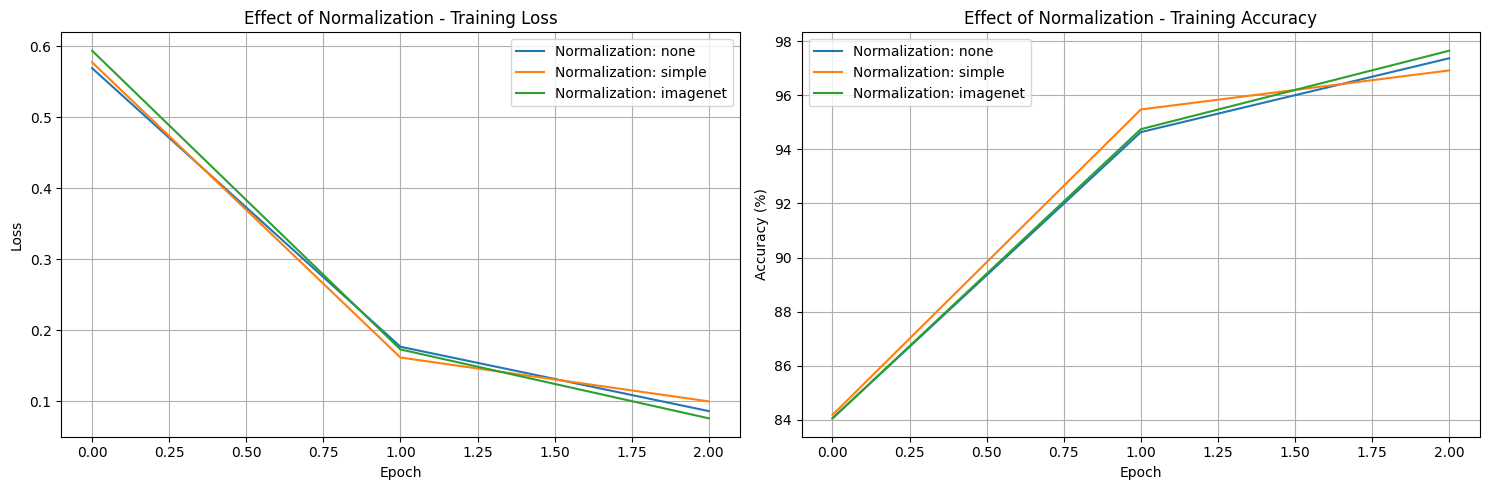


Normalization Experiment Results:
none: 0.9875
simple: 0.9909
imagenet: 0.9909

🧪 Running Weight Initialization Experiment...

=== EXPERIMENT: EFFECT OF WEIGHT INITIALIZATION ===

Running with initialization: default

Epoch 1/3
------------------------------


Validation: 100%|██████████| 53/53 [02:14<00:00,  2.55s/it, Loss=2.8324, Acc=0.3547]


★ New best model saved! Val Acc: 0.2783

Epoch 2/3
------------------------------


Validation: 100%|██████████| 53/53 [02:13<00:00,  2.51s/it, Loss=2.8476, Acc=0.3834]


★ New best model saved! Val Acc: 0.3008

Epoch 3/3
------------------------------


Validation: 100%|██████████| 53/53 [02:17<00:00,  2.59s/it, Loss=2.0862, Acc=0.5932]


★ New best model saved! Val Acc: 0.4654

Training complete in 88m 8s
Best Val Acc: 0.4654 at epoch 3


Evaluating: 100%|██████████| 55/55 [02:28<00:00,  2.70s/it]


Test Accuracy (default): 0.4690

Running with initialization: xavier

Epoch 1/3
------------------------------


Validation: 100%|██████████| 53/53 [02:20<00:00,  2.66s/it, Loss=3.3031, Acc=0.2506]


★ New best model saved! Val Acc: 0.1966

Epoch 2/3
------------------------------


Validation: 100%|██████████| 53/53 [02:17<00:00,  2.60s/it, Loss=3.0020, Acc=0.3842]


★ New best model saved! Val Acc: 0.3014

Epoch 3/3
------------------------------


Validation: 100%|██████████| 53/53 [02:23<00:00,  2.72s/it, Loss=2.6615, Acc=0.4528]


★ New best model saved! Val Acc: 0.3552

Training complete in 88m 56s
Best Val Acc: 0.3552 at epoch 3


Evaluating: 100%|██████████| 55/55 [02:30<00:00,  2.73s/it]


Test Accuracy (xavier): 0.3540

Running with initialization: he

Epoch 1/3
------------------------------


Validation: 100%|██████████| 53/53 [02:10<00:00,  2.47s/it, Loss=3.1337, Acc=0.3170]


★ New best model saved! Val Acc: 0.2487

Epoch 2/3
------------------------------


Validation: 100%|██████████| 53/53 [02:14<00:00,  2.53s/it, Loss=2.6612, Acc=0.3925]


★ New best model saved! Val Acc: 0.3079

Epoch 3/3
------------------------------


Validation: 100%|██████████| 53/53 [02:09<00:00,  2.44s/it, Loss=2.2971, Acc=0.5343]


★ New best model saved! Val Acc: 0.4192

Training complete in 88m 8s
Best Val Acc: 0.4192 at epoch 3


Evaluating: 100%|██████████| 55/55 [02:18<00:00,  2.52s/it]


Test Accuracy (he): 0.4166

Running with initialization: poor

Epoch 1/3
------------------------------


Validation: 100%|██████████| 53/53 [02:14<00:00,  2.54s/it, Loss=43.7506, Acc=0.1819]


★ New best model saved! Val Acc: 0.1427

Epoch 2/3
------------------------------


Validation: 100%|██████████| 53/53 [02:16<00:00,  2.57s/it, Loss=33.4664, Acc=0.2619]


★ New best model saved! Val Acc: 0.2054

Epoch 3/3
------------------------------


Validation: 100%|██████████| 53/53 [02:12<00:00,  2.49s/it, Loss=30.7725, Acc=0.2815]


★ New best model saved! Val Acc: 0.2208

Training complete in 87m 20s
Best Val Acc: 0.2208 at epoch 3


Evaluating: 100%|██████████| 55/55 [02:21<00:00,  2.57s/it]


Test Accuracy (poor): 0.2316


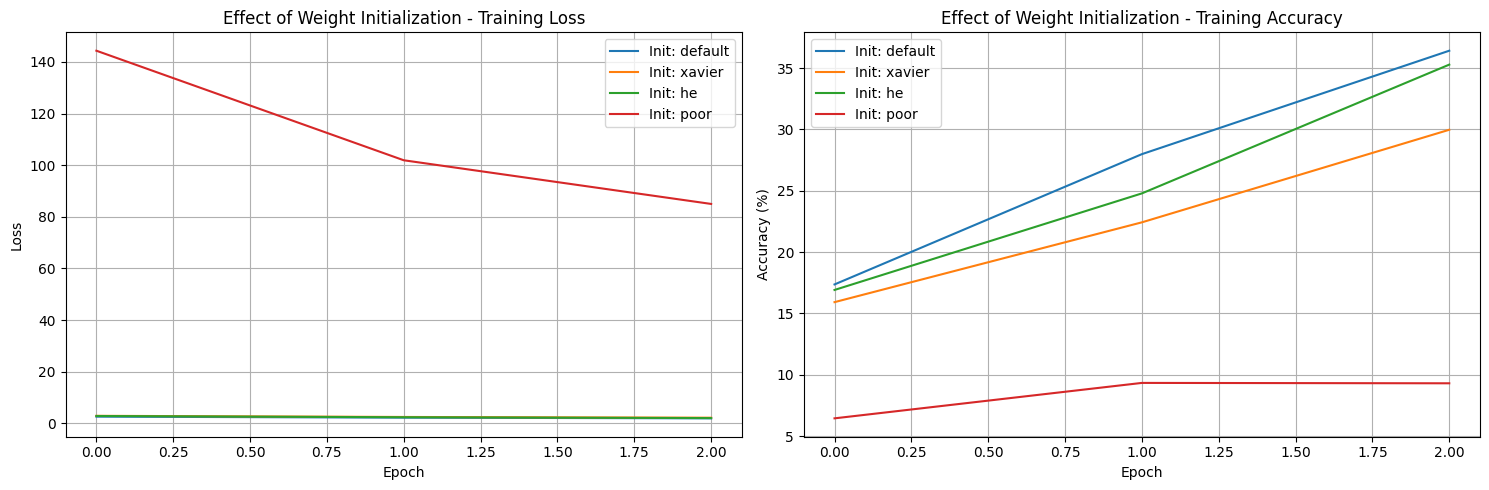


Weight Initialization Experiment Results:
default: 0.4690
xavier: 0.3540
he: 0.4166
poor: 0.2316

🧪 Running Optimizer Experiment...

=== EXPERIMENT: EFFECT OF OPTIMIZERS ===

Running with optimizer: sgd

Epoch 1/5
------------------------------


Validation: 100%|██████████| 53/53 [02:14<00:00,  2.53s/it, Loss=0.3216, Acc=1.1864]


★ New best model saved! Val Acc: 0.9307

Epoch 2/5
------------------------------


Validation: 100%|██████████| 53/53 [02:12<00:00,  2.51s/it, Loss=0.1274, Acc=1.2475]


★ New best model saved! Val Acc: 0.9787

Epoch 3/5
------------------------------


Validation: 100%|██████████| 53/53 [02:14<00:00,  2.53s/it, Loss=0.0720, Acc=1.2574]


★ New best model saved! Val Acc: 0.9864

Epoch 4/5
------------------------------


Validation: 100%|██████████| 53/53 [02:13<00:00,  2.51s/it, Loss=0.0593, Acc=1.2596]


★ New best model saved! Val Acc: 0.9882

Epoch 5/5
------------------------------


Validation: 100%|██████████| 53/53 [02:13<00:00,  2.51s/it, Loss=0.0534, Acc=1.2596]



Training complete in 77m 58s
Best Val Acc: 0.9882 at epoch 4


Evaluating: 100%|██████████| 55/55 [02:19<00:00,  2.53s/it]


Test Accuracy (sgd): 0.9880

Running with optimizer: sgd_momentum

Epoch 1/5
------------------------------


Validation: 100%|██████████| 53/53 [02:14<00:00,  2.53s/it, Loss=0.0759, Acc=1.2513]


★ New best model saved! Val Acc: 0.9816

Epoch 2/5
------------------------------


Validation: 100%|██████████| 53/53 [02:13<00:00,  2.53s/it, Loss=0.0541, Acc=1.2581]


★ New best model saved! Val Acc: 0.9870

Epoch 3/5
------------------------------


Validation: 100%|██████████| 53/53 [02:15<00:00,  2.55s/it, Loss=0.0377, Acc=1.2589]


★ New best model saved! Val Acc: 0.9876

Epoch 4/5
------------------------------


Validation:   4%|▍         | 2/53 [00:05<02:15,  2.65s/it, Loss=0.0005, Acc=1.0000]

In [ ]:
# =============================================================================
# RESNET18 HYPERPARAMETER TUNING IMPLEMENTATION
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import copy
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# =============================================================================
# ENHANCED RESNET18 MODEL WITH INITIALIZATION OPTIONS
# =============================================================================

def init_weights(m, method='he'):
    """Initialize weights based on specified method"""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if method == 'xavier':
            nn.init.xavier_uniform_(m.weight)
        elif method == 'he':
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        elif method == 'poor':
            # Poor initialization - too large values causing exploding gradients
            nn.init.uniform_(m.weight, -10, 10)
        elif method == 'default':
            pass  # Use PyTorch default initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def create_resnet18_model(num_classes, pretrained=True, init_method='he'):
    """Enhanced ResNet18 model with weight initialization options"""
    model = models.resnet18(pretrained=pretrained)

    if pretrained:
        # Freeze early layers, allow fine-tuning of later layers
        for name, param in model.named_parameters():
            if "layer4" not in name and "fc" not in name:
                param.requires_grad = False
    else:
        # Apply custom initialization if not using pretrained weights
        model.apply(lambda m: init_weights(m, init_method))

    # Replace final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, num_classes)
    )

    # Initialize FC weights
    init_weights(model.fc[1], init_method)

    return model

# =============================================================================
# DATA LOADING WITH NORMALIZATION OPTIONS
# =============================================================================

def create_data_transforms(normalization='imagenet'):
    """Create data transformations with different normalization options"""
    # Define normalization options
    norm_options = {
        'none': ([0, 0, 0], [1, 1, 1]),  # No normalization
        'simple': ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Simple [-1, 1] scaling
        'imagenet': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # ImageNet stats
    }

    mean, std = norm_options.get(normalization.lower(), norm_options['imagenet'])

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }
    return data_transforms

def create_dataloaders(data_dir, batch_size=32, num_workers=2, normalization='imagenet'):
    """Create data loaders with configurable normalization"""
    data_transforms = create_data_transforms(normalization)

    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Data directory not found: {data_dir}")

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(data_dir, split)
        if os.path.exists(split_dir):
            image_datasets[split] = datasets.ImageFolder(
                split_dir,
                transform=data_transforms[split]
            )
            dataloaders[split] = DataLoader(
                image_datasets[split],
                batch_size=batch_size,
                shuffle=(split == 'train'),
                num_workers=num_workers,
                pin_memory=True
            )
            dataset_sizes[split] = len(image_datasets[split])
        else:
            print(f"Warning: {split} directory not found at {split_dir}")

    if 'train' in image_datasets:
        class_names = image_datasets['train'].classes
        class_to_idx = image_datasets['train'].class_to_idx
    else:
        raise FileNotFoundError("Training data not found!")

    return {
        'dataloaders': dataloaders,
        'dataset_sizes': dataset_sizes,
        'class_names': class_names,
        'class_to_idx': class_to_idx
    }

# =============================================================================
# TRAINING UTILITIES
# =============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device, epoch_num, scheduler=None):
    """Training function with learning rate tracking"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    current_lr = optimizer.param_groups[0]['lr']

    pbar = tqdm(dataloader, desc=f"Epoch {epoch_num} - Training (LR: {current_lr:.2e})")

    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        current_loss = running_loss / ((batch_idx + 1) * inputs.size(0))
        current_acc = running_corrects.double() / ((batch_idx + 1) * inputs.size(0))
        pbar.set_postfix({'Loss': f'{current_loss:.4f}', 'Acc': f'{current_acc:.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc.item()

def validate_epoch(model, dataloader, criterion, device, phase="Validation"):
    """Validation function"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    pbar = tqdm(dataloader, desc=f"{phase}")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            current_loss = running_loss / ((batch_idx + 1) * inputs.size(0))
            current_acc = running_corrects.double() / ((batch_idx + 1) * inputs.size(0))
            pbar.set_postfix({'Loss': f'{current_loss:.4f}', 'Acc': f'{current_acc:.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc.item()

def evaluate_model(model, dataloader, device, class_names):
    """Model evaluation with metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    return {
        'confusion_matrix': cm,
        'confusion_matrix_percent': cm_percent,
        'classification_report': report,
        'accuracy': report['accuracy'],
        'all_preds': all_preds,
        'all_labels': all_labels,
        'all_probs': all_probs
    }

# =============================================================================
# VISUALIZATION AND PLOTTING UTILITIES
# =============================================================================

def plot_training_history(title, *histories):
    """Plot training loss and accuracy histories for comparison."""
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    for name, loss_history, _ in histories:
        plt.plot(loss_history, label=name)
    plt.title(f'{title} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    for name, _, acc_history in histories:
        plt.plot(acc_history, label=name)
    plt.title(f'{title} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def visualize_softmax_predictions(model, dataloader, device, class_names, num_samples=4):
    """Visualize softmax predictions for sample images"""
    model.eval()

    # Get a batch of data
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Move to device and get predictions
    images_gpu = images.to(device)
    with torch.no_grad():
        outputs = model(images_gpu)
        probabilities = F.softmax(outputs, dim=1)

    # Move back to CPU for visualization
    probabilities = probabilities.cpu().numpy()

    # Plot probabilities for the first few images
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(images))):
        plt.subplot(2, 2, i+1)
        plt.bar(range(len(class_names)), probabilities[i])
        pred_class = class_names[outputs[i].argmax().item()]
        true_class = class_names[labels[i]]
        plt.title(f'True: {true_class}, Pred: {pred_class}')
        plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
        plt.ylim(0, 1)
        plt.ylabel('Probability')

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN TRAINING FUNCTION
# =============================================================================

def train_model(model, dataloaders, criterion, optimizer, scheduler, device,
               num_epochs, model_dir, class_names, class_to_idx):
    """Complete training pipeline with history tracking"""
    os.makedirs(model_dir, exist_ok=True)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Train
        train_loss, train_acc = train_epoch(
            model, dataloaders['train'], criterion, optimizer, device, epoch+1, scheduler)

        # Validate
        val_loss, val_acc = validate_epoch(model, dataloaders['val'], criterion, device)

        # Update scheduler
        if scheduler is not None:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc * 100)  # Convert to percentage
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc * 100)  # Convert to percentage
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())

            checkpoint_path = os.path.join(model_dir, "best_model.pt")
            torch.save({
                'model_state_dict': model.state_dict(),
                'class_to_idx': class_to_idx,
                'epoch': epoch+1,
                'val_acc': val_acc,
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, checkpoint_path)

            print(f"★ New best model saved! Val Acc: {best_acc:.4f}")

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f} at epoch {best_epoch+1}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

# =============================================================================
# HYPERPARAMETER EXPERIMENTS
# =============================================================================

def experiment_normalization(data_dir, epochs=5):
    """Experiment with different normalization strategies"""
    print("\n=== EXPERIMENT: EFFECT OF NORMALIZATION ===")

    norm_methods = ['none', 'simple', 'imagenet']
    results = {}
    histories = {}

    for norm in norm_methods:
        print(f"\nRunning with normalization: {norm}")

        # Create dataloaders with specific normalization
        data = create_dataloaders(data_dir, batch_size=32, normalization=norm)
        dataloaders = data['dataloaders']
        class_names = data['class_names']
        class_to_idx = data['class_to_idx']

        # Create model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = create_resnet18_model(len(class_names), pretrained=True, init_method='he')
        model = model.to(device)

        # Standard training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train
        model, history = train_model(
            model, dataloaders, criterion, optimizer, None, device,
            epochs, f"/content/drive/MyDrive/pokemon_results/norm_{norm}", class_names, class_to_idx
        )

        histories[f"Normalization: {norm}"] = (history['train_loss'], history['train_acc'])

        # Evaluate
        if 'test' in dataloaders:
            test_metrics = evaluate_model(model, dataloaders['test'], device, class_names)
            results[norm] = test_metrics['accuracy']
            print(f"Test Accuracy ({norm}): {test_metrics['accuracy']:.4f}")

    # Plot comparison
    plot_training_history("Effect of Normalization", *[
        (name, loss, acc) for name, (loss, acc) in histories.items()
    ])

    print("\nNormalization Experiment Results:")
    for norm, acc in results.items():
        print(f"{norm}: {acc:.4f}")

    return results

def experiment_weight_initialization(data_dir, epochs=5):
    """Experiment with different weight initialization strategies"""
    print("\n=== EXPERIMENT: EFFECT OF WEIGHT INITIALIZATION ===")

    init_methods = ['default', 'xavier', 'he', 'poor']
    results = {}
    histories = {}

    for init_method in init_methods:
        print(f"\nRunning with initialization: {init_method}")

        # Create dataloaders
        data = create_dataloaders(data_dir, batch_size=32)
        dataloaders = data['dataloaders']
        class_names = data['class_names']
        class_to_idx = data['class_to_idx']

        # Create model with specific initialization
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = create_resnet18_model(len(class_names), pretrained=False, init_method=init_method)
        model = model.to(device)

        # Standard training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train
        model, history = train_model(
            model, dataloaders, criterion, optimizer, None, device,
            epochs,f"/content/drive/MyDrive/pokemon_results/init_{init_method}", class_names, class_to_idx
        )

        histories[f"Init: {init_method}"] = (history['train_loss'], history['train_acc'])

        # Evaluate
        if 'test' in dataloaders:
            test_metrics = evaluate_model(model, dataloaders['test'], device, class_names)
            results[init_method] = test_metrics['accuracy']
            print(f"Test Accuracy ({init_method}): {test_metrics['accuracy']:.4f}")

    # Plot comparison
    plot_training_history("Effect of Weight Initialization", *[
        (name, loss, acc) for name, (loss, acc) in histories.items()
    ])

    print("\nWeight Initialization Experiment Results:")
    for init, acc in results.items():
        print(f"{init}: {acc:.4f}")

    return results

def experiment_optimizers(data_dir, epochs=10):
    """Experiment with different optimizers"""
    print("\n=== EXPERIMENT: EFFECT OF OPTIMIZERS ===")

    optimizers_config = {
        'sgd': {'class': optim.SGD, 'lr': 0.01, 'kwargs': {}},
        'sgd_momentum': {'class': optim.SGD, 'lr': 0.01, 'kwargs': {'momentum': 0.9}},
        'rmsprop': {'class': optim.RMSprop, 'lr': 0.001, 'kwargs': {}},
        'adam': {'class': optim.Adam, 'lr': 0.001, 'kwargs': {}}
    }
    results = {}
    histories = {}

    for opt_name, opt_config in optimizers_config.items():
        print(f"\nRunning with optimizer: {opt_name}")

        # Create dataloaders
        data = create_dataloaders(data_dir, batch_size=32)
        dataloaders = data['dataloaders']
        class_names = data['class_names']
        class_to_idx = data['class_to_idx']

        # Create model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = create_resnet18_model(len(class_names), pretrained=True, init_method='he')
        model = model.to(device)

        # Create optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = opt_config['class'](
            model.parameters(),
            lr=opt_config['lr'],
            **opt_config['kwargs']
        )

        # Train
        model, history = train_model(
            model, dataloaders, criterion, optimizer, None, device,
            epochs,  f"/content/drive/MyDrive/pokemon_results/opt_{opt_name}", class_names, class_to_idx
        )

        histories[f"Optimizer: {opt_name}"] = (history['train_loss'], history['train_acc'])

        # Evaluate
        if 'test' in dataloaders:
            test_metrics = evaluate_model(model, dataloaders['test'], device, class_names)
            results[opt_name] = test_metrics['accuracy']
            print(f"Test Accuracy ({opt_name}): {test_metrics['accuracy']:.4f}")

    # Plot comparison
    plot_training_history("Effect of Different Optimizers", *[
        (name, loss, acc) for name, (loss, acc) in histories.items()
    ])

    print("\nOptimizer Experiment Results:")
    for opt, acc in results.items():
        print(f"{opt}: {acc:.4f}")

    return results

def experiment_learning_rate_decay(data_dir, epochs=15):
    """Experiment with different learning rate decay strategies"""
    print("\n=== EXPERIMENT: EFFECT OF LEARNING RATE DECAY ===")

    results = {}
    histories = {}

    schedulers_config = {
        'constant': None,
        'step': lambda opt: StepLR(opt, step_size=5, gamma=0.1),
        'exponential': lambda opt: ExponentialLR(opt, gamma=0.9),
        'cosine': lambda opt: CosineAnnealingLR(opt, T_max=epochs)
    }

    for sched_name, sched_fn in schedulers_config.items():
        print(f"\nRunning with scheduler: {sched_name}")

        # Create dataloaders
        data = create_dataloaders(data_dir, batch_size=32)
        dataloaders = data['dataloaders']
        class_names = data['class_names']
        class_to_idx = data['class_to_idx']

        # Create model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = create_resnet18_model(len(class_names), pretrained=True, init_method='he')
        model = model.to(device)

        # Create optimizer and scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = sched_fn(optimizer) if sched_fn else None

        # Train
        model, history = train_model(
            model, dataloaders, criterion, optimizer, scheduler, device,
            epochs, f"/content/drive/MyDrive/pokemon_results/sched_{sched_name}", class_names, class_to_idx
        )

        histories[f"LR Decay: {sched_name}"] = (history['train_loss'], history['train_acc'])

        # Evaluate
        if 'test' in dataloaders:
            test_metrics = evaluate_model(model, dataloaders['test'], device, class_names)
            results[sched_name] = test_metrics['accuracy']
            print(f"Test Accuracy ({sched_name}): {test_metrics['accuracy']:.4f}")

    # Plot comparison
    plot_training_history("Effect of Learning Rate Decay", *[
        (name, loss, acc) for name, (loss, acc) in histories.items()
    ])

    print("\nLearning Rate Decay Experiment Results:")
    for sched, acc in results.items():
        print(f"{sched}: {acc:.4f}")

    return results

def experiment_batch_size(data_dir, epochs=5):
    """Experiment with different batch sizes"""
    print("\n=== EXPERIMENT: EFFECT OF BATCH SIZE ===")

    batch_sizes = [16, 32, 64, 128]
    results = {}
    histories = {}

    for batch_size in batch_sizes:
        print(f"\nRunning with batch size: {batch_size}")

        # Create dataloaders
        data = create_dataloaders(data_dir, batch_size=batch_size)
        dataloaders = data['dataloaders']
        class_names = data['class_names']
        class_to_idx = data['class_to_idx']

        # Create model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = create_resnet18_model(len(class_names), pretrained=True, init_method='he')
        model = model.to(device)

        # Create optimizer (adjust learning rate for batch size)
        criterion = nn.CrossEntropyLoss()
        lr = 0.001 * (batch_size / 32)  # Scale LR with batch size
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train
        model, history = train_model(
            model, dataloaders, criterion, optimizer, None, device,
            epochs, f"/content/drive/MyDrive/pokemon_results/batch_{batch_size}", class_names, class_to_idx
        )

        histories[f"Batch Size: {batch_size}"] = (history['train_loss'], history['train_acc'])

        # Evaluate
        if 'test' in dataloaders:
            test_metrics = evaluate_model(model, dataloaders['test'], device, class_names)
            results[batch_size] = test_metrics['accuracy']
            print(f"Test Accuracy (batch size {batch_size}): {test_metrics['accuracy']:.4f}")

    # Plot comparison
    plot_training_history("Effect of Batch Size", *[
        (name, loss, acc) for name, (loss, acc) in histories.items()
    ])

    print("\nBatch Size Experiment Results:")
    for bs, acc in results.items():
        print(f"{bs}: {acc:.4f}")

    return results

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def run_all_experiments(data_dir):
    """Run all hyperparameter experiments"""
    print("🚀 Starting comprehensive hyperparameter experiments...")
    print(f"📁 Using data directory: {data_dir}")

    # Check if data directory exists
    if not os.path.exists(data_dir):
        print(f"❌ Error: Data directory not found at {data_dir}")
        print("Please update the data_dir variable with the correct path to your pokemon_final_dataset")
        return

    # Create results directory
    os.makedirs("/content/drive/MyDrive/pokemon_results", exist_ok=True)

    # Run experiments with shorter epochs for quick testing
    print("\n" + "="*60)

    try:
        # Experiment 1: Normalization
        print("🧪 Running Normalization Experiment...")
        norm_results = experiment_normalization(data_dir, epochs=3)

        # Experiment 2: Weight Initialization
        print("\n🧪 Running Weight Initialization Experiment...")
        init_results = experiment_weight_initialization(data_dir, epochs=3)

        # Experiment 3: Optimizers
        print("\n🧪 Running Optimizer Experiment...")
        opt_results = experiment_optimizers(data_dir, epochs=5)

        # Experiment 4: Learning Rate Decay
        print("\n🧪 Running Learning Rate Decay Experiment...")
        lr_results = experiment_learning_rate_decay(data_dir, epochs=8)

        # Experiment 5: Batch Size
        print("\n🧪 Running Batch Size Experiment...")
        batch_results = experiment_batch_size(data_dir, epochs=3)

        # Print final summary
        print("\n" + "="*60)
        print("🎯 FINAL EXPERIMENTAL RESULTS SUMMARY")
        print("="*60)

        print("\n📊 Normalization Experiment:")
        for name, acc in norm_results.items():
            print(f"  {name:15}: {acc:.4f}")

        print("\n🎯 Weight Initialization Experiment:")
        for name, acc in init_results.items():
            print(f"  {name:15}: {acc:.4f}")

        print("\n⚡ Optimizer Experiment:")
        for name, acc in opt_results.items():
            print(f"  {name:15}: {acc:.4f}")

        print("\n📈 Learning Rate Decay Experiment:")
        for name, acc in lr_results.items():
            print(f"  {name:15}: {acc:.4f}")

        print("\n📦 Batch Size Experiment:")
        for name, acc in batch_results.items():
            print(f"  Batch {name:8}: {acc:.4f}")

        print("\n✅ All experiments completed successfully!")
        print("📁 Results and models saved in 'results/' directory")

    except Exception as e:
        print(f"❌ Error during experiments: {str(e)}")
        print("Please check your data directory path and ensure it has train/val/test subdirectories")

if __name__ == "__main__":
    data_dir = "/content/drive/MyDrive/pokemon_final_dataset"

    print("🔥 ResNet18 Hyperparameter Tuning for Pokemon Classification")
    print("=" * 60)

    # Run all experiments
    run_all_experiments(data_dir)